In [1]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

In [1]:
from Preprocessing import * 

prep = Preprocessing()

merged_hornsea = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_hornsea":"nc_files", "ncep_gfs_hornsea":"nc_files"},
                                              deployment = False, merge_with_outage_data = True, json_file_path = "nc_files/REMIT", energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

merged_pes = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_pes":"nc_files", "ncep_gfs_pes":"nc_files"},
          deployment = False, merge_with_outage_data = False, energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, ) 

# merged_demand = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_demand":"nc_files", "ncep_gfs_demand":"nc_files"},
#           deployment = False, merge_with_outage_data = True, energy_data_dict = {"Energy_data":"csv_files"},
#                                               non_numerical_columns = ["unavailabilityType", "affectedUnit"],
#                                               fft = False, )

INFO:root:Perform data cleaning on the weather data...
INFO:root:Merge weather stations...
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:658: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  weather_data = weather_data.resample("30min", level = 1).mean().interpolate("time")
INFO:root:Merge with outages data (REMIT)...
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:326: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  outages_df = pd.concat([outages_df, json_data_with_date_ranges])
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:326: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

In [2]:
merged_demand = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_demand":"nc_files", "ncep_gfs_demand":"nc_files"},
          deployment = False, merge_with_outage_data = True, energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

INFO:root:Perform data cleaning on the weather data...
INFO:root:Merge weather stations...
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:658: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  weather_data = weather_data.resample("30min", level = 1).mean().interpolate("time")
INFO:root:Merge with outages data (REMIT)...
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:326: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  outages_df = pd.concat([outages_df, json_data_with_date_ranges])
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:326: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

In [15]:
merged_hornsea.to_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes.to_parquet("preprocessed_pes_with_energy.parquet")

In [1]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea.drop(["rel_hum", "rel_hum_diff"], axis = 1), deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

In [2]:
feature_engineerer_wind.train_val_test_split_by_year(merged_hornsea)

In [3]:
feature_engineerer_wind.y_test

dtm
2023-05-21 23:30:00+00:00    571.652
2023-05-22 00:00:00+00:00    574.332
2023-05-22 00:30:00+00:00    569.412
2023-05-22 01:00:00+00:00    570.152
2023-05-22 01:30:00+00:00    556.232
                              ...   
2023-11-19 21:30:00+00:00    578.801
2023-11-19 22:00:00+00:00    580.570
2023-11-19 22:30:00+00:00    581.061
2023-11-19 23:00:00+00:00    580.581
2023-11-19 23:30:00+00:00    579.661
Name: Wind_MWh_credit, Length: 8737, dtype: float64

In [5]:
feature_engineerer_wind.y_train

dtm
2020-09-20 00:00:00+00:00    498.142
2020-09-20 00:30:00+00:00    478.788
2020-09-20 01:00:00+00:00    470.522
2020-09-20 01:30:00+00:00    482.183
2020-09-20 02:00:00+00:00    459.216
                              ...   
2022-05-21 21:00:00+00:00     95.865
2022-05-21 21:30:00+00:00    126.591
2022-05-21 22:00:00+00:00    162.407
2022-05-21 22:30:00+00:00    181.824
2022-05-21 23:00:00+00:00    168.232
Name: Wind_MWh_credit, Length: 29231, dtype: float64

In [3]:
importlib.reload(model_utils)
import numpy as np
quantiles = np.arange(0.1, 1.0, 0.1).round(2)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind.pinball_score()}")

[LightGBM] [Info] Total Bins 11450
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 63
[LightGBM] [Info] Start training from score 9.924001
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 9.80718	valid's quantile: 11.6834
[100]	train's quantile: 8.64384	valid's quantile: 11.6295
Early stopping, best iteration is:
[59]	train's quantile: 9.51407	valid's quantile: 11.5901
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_wind\lgbm_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 11450
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 63
[LightGBM] [Info] Start training from score 46.169998
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 13.8969	valid's quantile: 17.9107
[100]	train's quantile: 12.4469	valid's quantile: 17.9942
Early stopping, best iteration is:
[70]	train's quantile: 13.2764	valid's quantile: 17.747
Saved Q

In [13]:
lgbm_model_wind.models

{0.1: LGBMRegressor(alpha=0.1, force_col_wise=True, n_estimators=1000,
               objective='quantile'),
 0.2: LGBMRegressor(alpha=0.2, force_col_wise=True, n_estimators=1000,
               objective='quantile'),
 0.3: LGBMRegressor(alpha=0.3, force_col_wise=True, n_estimators=1000,
               objective='quantile'),
 0.4: LGBMRegressor(alpha=0.4, force_col_wise=True, n_estimators=1000,
               objective='quantile'),
 0.5: LGBMRegressor(alpha=0.5, force_col_wise=True, n_estimators=1000,
               objective='quantile'),
 0.6: LGBMRegressor(alpha=0.6, force_col_wise=True, n_estimators=1000,
               objective='quantile'),
 0.7: LGBMRegressor(alpha=0.7, force_col_wise=True, n_estimators=1000,
               objective='quantile'),
 0.8: LGBMRegressor(alpha=0.8, force_col_wise=True, n_estimators=1000,
               objective='quantile'),
 0.9: LGBMRegressor(alpha=0.9, force_col_wise=True, n_estimators=1000,
               objective='quantile')}

In [3]:
lgbm_model_wind.q_predictions

{'true': array([571.652, 574.332, 569.412, ..., 581.061, 580.581, 579.661]),
 '0.1': array([351.81940979, 369.89608532, 351.4461631 , ..., 521.60582747,
        525.76198012, 531.52477237]),
 '0.2': array([437.51190192, 444.56482392, 446.77225892, ..., 530.18055143,
        544.55706137, 539.76167082]),
 '0.3': array([460.11864881, 472.78871213, 470.66575377, ..., 554.8706124 ,
        554.89231571, 555.54037229]),
 '0.4': array([478.25294305, 492.25353823, 488.62993928, ..., 555.73957364,
        557.77948086, 557.1578041 ]),
 '0.5': array([496.92749343, 511.60048842, 507.83718389, ..., 562.38377187,
        564.13799742, 563.21394693]),
 '0.6': array([523.9395136 , 523.3126304 , 535.39536247, ..., 564.87448899,
        564.92433483, 563.49972716]),
 '0.7': array([530.55952654, 538.07124279, 541.23644944, ..., 565.32930441,
        567.5444593 , 566.33387701]),
 '0.8': array([558.40213909, 558.22034811, 555.56713137, ..., 569.20438084,
        569.31745689, 570.84479426]),
 '0.9': arr

In [7]:
lg2.pinball_score()

22.61773382875047

In [8]:
lg2.best_params

{0.1: LGBMRegressor(alpha=0.1, boosting='gbdt', extra_trees=False,
               force_col_wise=True, learning_rate=0.0599, max_depth=13,
               min_data_in_leaf=263, n_estimators=1500, num_iterations=200,
               num_leaves=28, objective='quantile', random_state=42, verbose=-1),
 0.2: LGBMRegressor(alpha=0.2, boosting='gbdt', extra_trees=False,
               force_col_wise=True, learning_rate=0.0359, max_depth=11,
               min_data_in_leaf=168, n_estimators=1500, num_iterations=500,
               num_leaves=73, objective='quantile', random_state=42, verbose=-1),
 0.3: LGBMRegressor(alpha=0.3, boosting='gbdt', extra_trees=False,
               force_col_wise=True, learning_rate=0.0359, max_depth=13,
               min_data_in_leaf=452, n_estimators=1000, num_iterations=500,
               num_leaves=100, objective='quantile', random_state=42,
               verbose=-1),
 0.4: LGBMRegressor(alpha=0.4, boosting='gbdt', extra_trees=False,
               force_col_w

In [6]:
from model_utils import *
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from random import randint
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.metrics import make_scorer, mean_pinball_loss
quantiles = np.arange(0.1, 1.0, 0.1).round(2)
model_save_dir_qr = "lgbm_model_wind"



# Define pinball loss function
def pinball_loss(y_true, y_pred, quantile=0.9):
    delta = y_true - y_pred
    loss = np.where(delta > 0, quantile * delta, (1 - quantile) * - delta)
    return np.mean(loss)

# Create a custom scorer for quantile regression (e.g., 90th percentile)
quantile = 0.9
scorer = make_scorer(pinball_loss, greater_is_better=False, quantile=quantile)

class LG(model_utils.LGBMRegressorModel):
    def __init__(self, feature_engineerer, quantiles, model_save_dir, load_pretrained):
        super().__init__(feature_engineerer, quantiles, model_save_dir, load_pretrained)
        self.best_params = dict()

    def train_and_predict(self):
        """Train the LGBMRegressor models or use the pretrained ones."""
        for quantile in self.quantiles:
            if not self.load_pretrained or quantile not in self.models:

                # Create a custom scorer for quantile regression (e.g., 90th percentile)
                quantile_now = quantile
                scorer = make_scorer(pinball_loss, quantile=quantile_now)
                

                params = {
                    "alpha":[quantile],
                    'boosting': ["gbdt", "dart"],
                    "force_col_wise": [True],
                    "num_iterations": [100, 200, 500],
                    "num_leaves": np.linspace(20, 100, 10, dtype = int).tolist(),
                    "max_depth": np.linspace(5, 15, 6, dtype = int).tolist(),
                    'learning_rate': np.logspace(-3, -1, 10).round(4).tolist(),
                    "n_estimators": [500, 1000, 1500],
                    #"subsample_for_bin": [],
                    'objective': ['quantile'],
                    #"min_split_gain": [],
                    #"min_sum_hessian_in_leaf:[] #for overfitting"
                    #"min_child_weight": [45],
                    # "min_child_samples":[20],
                    "min_data_in_leaf":np.linspace(50, 500, 20, dtype = int).tolist(),
                    #"tree_trainer":["serial", "feature", "data", "voting"],
                    # "feature_fraction_bynode": [1.0, 0.8, 0.5],
                    # "feature_fraction":[0.5, 0.8, 1.0],
                    # "bagging_fraction":[0.5, 0.8, 1.0],
                    #"subsample": [],
                    #"subsample_freq": [],
                    # "colsample_bytree": [0.3, 0.5, 1],
                    # "reg_alpha": np.logspace(-3, -1, 10).tolist(),
                    # "reg_lambda": np.logspace(-2, -1, 10).tolist(),
                    "random_state": [42],
                    "verbose":[-1],
                    #"device_type":["cuda"],
                    "extra_trees":[False],
                    # "path_smooth":[0.0, 0.2]
                    #"importance_type":[]
                }
                # Train a new model for this quantile
                # qr_lgbm1 = lgb.LGBMRegressor(objective='quantile', alpha=quantile, n_estimators=1000, force_col_wise=True, params = params)
                qr_lgbm1 = lgb.LGBMRegressor()
                cv = TimeSeriesSplit(2)
                qr_lgbm = RandomizedSearchCV(qr_lgbm1, param_distributions = params, cv = cv, n_iter = 20, 
                                             #scoring = scorer
                                             )
                qr_lgbm.fit(
                    self.feature_engineerer.X_train, 
                    self.feature_engineerer.y_train,
                    eval_set=[(self.feature_engineerer.X_train, self.feature_engineerer.y_train), 
                              (self.feature_engineerer.X_val, self.feature_engineerer.y_val)],
                    eval_names=['train', 'valid'],
                    eval_metric='quantile',
                    callbacks=[early_stopping(stopping_rounds=20), log_evaluation(50)]
                )

                # Save the model
                model_filename = os.path.join(self.model_save_dir, f"lgbm_model_quantile_{quantile}.pkl")
                self.best_params[quantile] = qr_lgbm.best_estimator_
                joblib.dump(qr_lgbm.best_estimator_, model_filename)
                print(f"Saved Quantile Regressor model for quantile {quantile} to {model_filename}")

                # Store the model for prediction
                self.models[quantile] = qr_lgbm.best_estimator_
            else:
                print(f"Using the loaded pretrained Quantile Regressor model for quantile {quantile}")

            # Predict and store the results
            self.q_predictions[str(quantile)] = self.models[quantile].predict(self.feature_engineerer.X_test)

        #sort results
        self.q_predictions = self.sort_quantiles(self.q_predictions, self.quantiles)
        self.q_predictions = self.replace_neg_values(self.q_predictions, self.quantiles)

        # **Set models_loaded to True after training so predict can be called immediately**
        self.models_loaded = True


lg2 = LG(feature_engineerer_wind, quantiles, model_save_dir = model_save_dir_qr, load_pretrained = False)
lg2.train_and_predict()

c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 27.5479	valid's quantile: 27.0699
[100]	train's quantile: 25.5986	valid's quantile: 25.3522
[150]	train's quantile: 23.9116	valid's quantile: 23.8303
[200]	train's quantile: 22.37	valid's quantile: 22.4692
Did not meet early stopping. Best iteration is:
[200]	train's quantile: 22.37	valid's quantile: 22.4692
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 28.076	valid's quantile: 27.5484
[100]	train's quantile: 26.7764	valid's quantile: 26.2834
[150]	train's quantile: 25.2882	valid's quantile: 24.7744
[200]	train's quantile: 23.893	valid's quantile: 23.4116
Did not meet early stopping. Best iteration is:
[200]	train's quantile: 23.893	valid's quantile: 23.4116
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 28.7761	valid's quantile: 28.1419
[100]	train's quantile: 28.0978	valid's quantile: 27.486


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's quantile: 27.4124	valid's quantile: 26.8678
[200]	train's quantile: 26.6707	valid's quantile: 26.2107
Did not meet early stopping. Best iteration is:
[200]	train's quantile: 26.6707	valid's quantile: 26.2107
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 28.8504	valid's quantile: 28.2875
[100]	train's quantile: 28.4401	valid's quantile: 27.8922
[150]	train's quantile: 27.9408	valid's quantile: 27.4111
[200]	train's quantile: 27.4452	valid's quantile: 26.9365
Did not meet early stopping. Best iteration is:
[200]	train's quantile: 27.4452	valid's quantile: 26.9365
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 26.7989	valid's quantile: 26.3022
[100]	train's quantile: 23.9278	valid's quantile: 23.5801
[150]	train's quantile: 21.4468	valid's quantile: 21.2926
[200]	train's quantile: 19.3997	valid's quantile: 19.4291
[250]	train's quantile: 17.6371	valid's quantile: 17.8247
[300]	train's quantile: 16.190

c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[400]	train's quantile: 14.2389	valid's quantile: 14.9176
[450]	train's quantile: 13.6938	valid's quantile: 14.4688
[500]	train's quantile: 13.2914	valid's quantile: 14.1128
Did not meet early stopping. Best iteration is:
[500]	train's quantile: 13.2914	valid's quantile: 14.1128
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 27.4194	valid's quantile: 26.8943
[100]	train's quantile: 25.1767	valid's quantile: 24.6585
[150]	train's quantile: 22.979	valid's quantile: 22.5644


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's quantile: 20.7276	valid's quantile: 20.498
[250]	train's quantile: 18.796	valid's quantile: 18.7246
[300]	train's quantile: 17.0362	valid's quantile: 17.1883
[350]	train's quantile: 15.6359	valid's quantile: 15.9621
[400]	train's quantile: 14.5257	valid's quantile: 14.9886
[450]	train's quantile: 13.6914	valid's quantile: 14.2432
[500]	train's quantile: 13.0807	valid's quantile: 13.6798
Did not meet early stopping. Best iteration is:
[500]	train's quantile: 13.0807	valid's quantile: 13.6798


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 18.0074	valid's quantile: 18.243
[100]	train's quantile: 13.1407	valid's quantile: 14.2379
[150]	train's quantile: 11.5425	valid's quantile: 13.1287
[200]	train's quantile: 11.0203	valid's quantile: 12.959
[250]	train's quantile: 10.7465	valid's quantile: 12.9238
Early stopping, best iteration is:
[248]	train's quantile: 10.7532	valid's quantile: 12.917
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 18.0121	valid's quantile: 19.0442


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 12.2641	valid's quantile: 14.3569
[150]	train's quantile: 10.2787	valid's quantile: 13.0004
[200]	train's quantile: 9.4464	valid's quantile: 12.7094
[250]	train's quantile: 9.04756	valid's quantile: 12.6322
Early stopping, best iteration is:
[257]	train's quantile: 9.01062	valid's quantile: 12.6251
[50]	train's quantile: 27.0225	valid's quantile: 26.8029
[100]	train's quantile: 25.8789	valid's quantile: 25.8696


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 27.3767	valid's quantile: 27.1417
[100]	train's quantile: 26.339	valid's quantile: 26.2667
[50]	train's quantile: 13.8012	valid's quantile: 14.6967
[100]	train's quantile: 12.7232	valid's quantile: 13.8135


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 12.1999	valid's quantile: 13.3937
[200]	train's quantile: 12.3365	valid's quantile: 13.527
[50]	train's quantile: 13.338	valid's quantile: 13.8797


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 12.0015	valid's quantile: 12.9242
[150]	train's quantile: 11.3299	valid's quantile: 12.4898
[200]	train's quantile: 11.4314	valid's quantile: 12.5759
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 14.158	valid's quantile: 15.3449
[100]	train's quantile: 11.937	valid's quantile: 13.7047
[150]	train's quantile: 11.3539	valid's quantile: 13.5317
[200]	train's quantile: 11.0441	valid's quantile: 13.4296
[250]	train's quantile: 10.8279	valid's quantile: 13.2295


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's quantile: 10.758	valid's quantile: 13.2388
[350]	train's quantile: 10.6803	valid's quantile: 13.1842
[400]	train's quantile: 10.6084	valid's quantile: 13.1716
[450]	train's quantile: 10.5969	valid's quantile: 13.219
[500]	train's quantile: 10.5722	valid's quantile: 13.2364
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 14.4846	valid's quantile: 14.9554
[100]	train's quantile: 11.0316	valid's quantile: 12.3942
[150]	train's quantile: 10.2616	valid's quantile: 12.21
[200]	train's quantile: 9.94668	valid's quantile: 12.2255
[250]	train's quantile: 9.71261	valid's quantile: 12.2468
[300]	train's quantile: 9.51582	valid's quantile: 12.3024
[350]	train's quantile: 9.37193	valid's quantile: 12.3203
[400]	train's quantile: 9.26364	valid's quantile: 12.3575
[450]	train's quantile: 9.16602	valid's quantile: 12.3841
[500]	train's quantile: 9.09444	valid's quantile: 12.4084


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 28.9572	valid's quantile: 28.3727
[100]	train's quantile: 28.8333	valid's quantile: 28.2518
[150]	train's quantile: 28.7693	valid's quantile: 28.1895
[200]	train's quantile: 28.7171	valid's quantile: 28.1407


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 29.0725	valid's quantile: 28.4988
[100]	train's quantile: 28.9741	valid's quantile: 28.4005
[150]	train's quantile: 28.9225	valid's quantile: 28.3506
[200]	train's quantile: 28.8861	valid's quantile: 28.3148
[50]	train's quantile: 28.9947	valid's quantile: 28.4441
[100]	train's quantile: 28.8736	valid's quantile: 28.3545


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 29.0749	valid's quantile: 28.534
[100]	train's quantile: 28.9906	valid's quantile: 28.4643
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 26.2533	valid's quantile: 25.9095
[100]	train's quantile: 23.4635	valid's quantile: 23.4461


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 26.7896	valid's quantile: 26.153
[100]	train's quantile: 24.1942	valid's quantile: 23.5507
[50]	train's quantile: 27.2367	valid's quantile: 26.6753
[100]	train's quantile: 26.2766	valid's quantile: 25.6709


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 25.3736	valid's quantile: 24.9159
[200]	train's quantile: 24.8718	valid's quantile: 24.5377
[250]	train's quantile: 23.6184	valid's quantile: 23.4886
[300]	train's quantile: 22.6676	valid's quantile: 22.6897
[350]	train's quantile: 21.9414	valid's quantile: 21.942
[400]	train's quantile: 21.6089	valid's quantile: 21.614
[450]	train's quantile: 21.4102	valid's quantile: 21.446
[500]	train's quantile: 20.1749	valid's quantile: 20.3173
[50]	train's quantile: 27.7491	valid's quantile: 27.2543
[100]	train's quantile: 26.9097	valid's quantile: 26.4574


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 26.279	valid's quantile: 25.8191
[200]	train's quantile: 25.7369	valid's quantile: 25.2501
[250]	train's quantile: 24.5922	valid's quantile: 24.119
[300]	train's quantile: 23.6641	valid's quantile: 23.2263
[350]	train's quantile: 22.7708	valid's quantile: 22.3909
[400]	train's quantile: 22.3424	valid's quantile: 21.9978
[450]	train's quantile: 22.0979	valid's quantile: 21.7767
[500]	train's quantile: 20.7212	valid's quantile: 20.4925


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 26.2716	valid's quantile: 25.9342
[100]	train's quantile: 23.4092	valid's quantile: 23.429
[150]	train's quantile: 21.0703	valid's quantile: 21.261
[200]	train's quantile: 19.1145	valid's quantile: 19.5003
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 27.1641	valid's quantile: 26.6496
[100]	train's quantile: 24.6843	valid's quantile: 24.1941
[150]	train's quantile: 22.3899	valid's quantile: 22.0029
[200]	train's quantile: 20.1392	valid's quantile: 19.9513
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 28.7749	valid's quantile: 28.1366
[100]	train's quantile: 28.0586	valid's quantile: 27.4222
[150]	train's quantile: 27.3526	valid's quantile: 26.7613


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's quantile: 26.6068	valid's quantile: 26.0861
[250]	train's quantile: 25.9077	valid's quantile: 25.4581
[300]	train's quantile: 25.2696	valid's quantile: 24.8759
[350]	train's quantile: 24.6068	valid's quantile: 24.3022
[400]	train's quantile: 23.9919	valid's quantile: 23.7559
[450]	train's quantile: 23.4175	valid's quantile: 23.2195
[500]	train's quantile: 22.8847	valid's quantile: 22.6939


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 28.8729	valid's quantile: 28.3093
[100]	train's quantile: 28.4972	valid's quantile: 27.9508
[150]	train's quantile: 28.1078	valid's quantile: 27.5818
[200]	train's quantile: 27.6335	valid's quantile: 27.1163
[250]	train's quantile: 27.1607	valid's quantile: 26.6545
[300]	train's quantile: 26.6783	valid's quantile: 26.1718
[350]	train's quantile: 26.2068	valid's quantile: 25.7069
[400]	train's quantile: 25.7669	valid's quantile: 25.2709
[450]	train's quantile: 25.3988	valid's quantile: 24.9196
[500]	train's quantile: 24.9758	valid's quantile: 24.5044
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 10.3113	valid's quantile: 13.4729
[100]	train's quantile: 10.0467	valid's quantile: 13.7352
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 9.15957	valid's quantile: 13.288
[100]	train's quantile: 8.10149	valid's quantile: 13.3228
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 23.9995	valid's quantile: 24.1831
[100]	train's quantile: 20.0697	valid's quantile: 20.5976
[150]	train's quantile: 17.169	valid's quantile: 18.1794
[200]	train's quantile: 15.0474	valid's quantile: 16.5602


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[250]	train's quantile: 13.5658	valid's quantile: 15.4097
[300]	train's quantile: 12.5702	valid's quantile: 14.6751
[350]	train's quantile: 11.8959	valid's quantile: 14.2483
[400]	train's quantile: 11.4302	valid's quantile: 14.0009
[450]	train's quantile: 11.1009	valid's quantile: 13.8385
[500]	train's quantile: 10.858	valid's quantile: 13.7436
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 24.9826	valid's quantile: 25.0704


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 20.7692	valid's quantile: 21.5388
[150]	train's quantile: 17.5308	valid's quantile: 18.7379
[200]	train's quantile: 14.9087	valid's quantile: 16.5815
[250]	train's quantile: 13.1548	valid's quantile: 15.2339
[300]	train's quantile: 11.9396	valid's quantile: 14.3555
[350]	train's quantile: 11.1219	valid's quantile: 13.8121
[400]	train's quantile: 10.5103	valid's quantile: 13.4513
[450]	train's quantile: 10.072	valid's quantile: 13.2226
[500]	train's quantile: 9.7493	valid's quantile: 13.0859


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 12.0523	valid's quantile: 13.5519
[100]	train's quantile: 10.9497	valid's quantile: 13.2179
[150]	train's quantile: 10.6614	valid's quantile: 13.1354
[200]	train's quantile: 10.5566	valid's quantile: 13.208
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 11.0535	valid's quantile: 13.2058
[100]	train's quantile: 9.66549	valid's quantile: 12.5004
[150]	train's quantile: 9.13898	valid's quantile: 12.373
[200]	train's quantile: 8.85218	valid's quantile: 12.4223
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 26.2385	valid's quantile: 25.8921


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 23.4888	valid's quantile: 23.4124
[150]	train's quantile: 21.0905	valid's quantile: 21.2756
[200]	train's quantile: 19.1746	valid's quantile: 19.5259
[250]	train's quantile: 17.5007	valid's quantile: 18.0129
[300]	train's quantile: 16.1309	valid's quantile: 16.8746
[350]	train's quantile: 15.0554	valid's quantile: 15.9907
[400]	train's quantile: 14.2685	valid's quantile: 15.3592
[450]	train's quantile: 13.6957	valid's quantile: 14.9025
[500]	train's quantile: 13.2702	valid's quantile: 14.5693


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 26.723	valid's quantile: 26.0767
[100]	train's quantile: 24.1616	valid's quantile: 23.4935
[150]	train's quantile: 21.8705	valid's quantile: 21.3245
[200]	train's quantile: 19.7585	valid's quantile: 19.4144
[250]	train's quantile: 17.9348	valid's quantile: 17.7637
[300]	train's quantile: 16.3361	valid's quantile: 16.3964
[350]	train's quantile: 15.0901	valid's quantile: 15.365
[400]	train's quantile: 14.0921	valid's quantile: 14.5519
[450]	train's quantile: 13.2941	valid's quantile: 13.925
[500]	train's quantile: 12.6879	valid's quantile: 13.4454


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 28.4539	valid's quantile: 27.9335
[100]	train's quantile: 28.1244	valid's quantile: 27.6112


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 28.6624	valid's quantile: 28.1508
[100]	train's quantile: 28.3512	valid's quantile: 27.8647


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 22.7265	valid's quantile: 23.013
[100]	train's quantile: 20.3596	valid's quantile: 20.9413
[150]	train's quantile: 19.1744	valid's quantile: 20.0088
[200]	train's quantile: 18.6034	valid's quantile: 19.5202
[50]	train's quantile: 23.3163	valid's quantile: 23.7299


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 20.7499	valid's quantile: 21.6213
[150]	train's quantile: 19.3689	valid's quantile: 20.4091
[200]	train's quantile: 18.697	valid's quantile: 19.7905
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 28.7918	valid's quantile: 28.1595
[100]	train's quantile: 28.0966	valid's quantile: 27.4847
[150]	train's quantile: 27.4075	valid's quantile: 26.8464
[200]	train's quantile: 26.6452	valid's quantile: 26.1552
[250]	train's quantile: 25.9948	valid's quantile: 25.5536
[300]	train's quantile: 25.3402	valid's quantile: 24.959


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[350]	train's quantile: 24.6985	valid's quantile: 24.3775
[400]	train's quantile: 24.1041	valid's quantile: 23.832
[450]	train's quantile: 23.5434	valid's quantile: 23.3176
[500]	train's quantile: 23.0254	valid's quantile: 22.8266
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 28.7787	valid's quantile: 28.2759


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 28.2892	valid's quantile: 27.8729
[150]	train's quantile: 27.7104	valid's quantile: 27.3941
[200]	train's quantile: 27.1662	valid's quantile: 26.9497
[250]	train's quantile: 26.6435	valid's quantile: 26.5064
[300]	train's quantile: 26.0729	valid's quantile: 25.9579
[350]	train's quantile: 25.4839	valid's quantile: 25.4438
[400]	train's quantile: 24.8576	valid's quantile: 24.8958
[450]	train's quantile: 24.2623	valid's quantile: 24.3916
[500]	train's quantile: 23.6627	valid's quantile: 23.9035


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 10.7239	valid's quantile: 12.2467
[100]	train's quantile: 8.71322	valid's quantile: 11.5938
[150]	train's quantile: 8.1424	valid's quantile: 11.5586
[200]	train's quantile: 7.81235	valid's quantile: 11.6282
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_wind\lgbm_model_quantile_0.1.pkl
[50]	train's quantile: 39.6025	valid's quantile: 39.3056
[100]	train's quantile: 34.6817	valid's quantile: 34.7324
[150]	train's quantile: 32.4207	valid's quantile: 32.6784


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	train's quantile: 31.4412	valid's quantile: 31.8494
[250]	train's quantile: 27.7308	valid's quantile: 28.5
[300]	train's quantile: 25.7011	valid's quantile: 26.7066
[350]	train's quantile: 24.5272	valid's quantile: 25.5643
[400]	train's quantile: 24.3013	valid's quantile: 25.3704
[450]	train's quantile: 24.3447	valid's quantile: 25.3955
[500]	train's quantile: 21.8436	valid's quantile: 23.2175


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 42.6936	valid's quantile: 42
[100]	train's quantile: 36.5602	valid's quantile: 36.3727
[150]	train's quantile: 33.515	valid's quantile: 33.5837
[200]	train's quantile: 32.049	valid's quantile: 32.3078
[250]	train's quantile: 27.8156	valid's quantile: 28.5225
[300]	train's quantile: 25.5526	valid's quantile: 26.4667
[350]	train's quantile: 24.0494	valid's quantile: 25.0862
[400]	train's quantile: 23.6009	valid's quantile: 24.6905
[450]	train's quantile: 23.6899	valid's quantile: 24.7287
[500]	train's quantile: 21.5219	valid's quantile: 22.6685


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 54.2783	valid's quantile: 53.1508
[100]	train's quantile: 53.642	valid's quantile: 52.5853
[150]	train's quantile: 53.495	valid's quantile: 52.5993
[200]	train's quantile: 53.4782	valid's quantile: 52.6923
[250]	train's quantile: 52.6737	valid's quantile: 52.0161
[300]	train's quantile: 51.9867	valid's quantile: 51.3966
[350]	train's quantile: 51.3504	valid's quantile: 50.813
[400]	train's quantile: 51.1118	valid's quantile: 50.6346
[450]	train's quantile: 50.9103	valid's quantile: 50.497
[500]	train's quantile: 49.7836	valid's quantile: 49.5554
[50]	train's quantile: 55.3379	valid's quantile: 54.2535


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 55.0755	valid's quantile: 54.0386
[150]	train's quantile: 54.9819	valid's quantile: 53.9699
[200]	train's quantile: 54.9521	valid's quantile: 53.9566
[250]	train's quantile: 54.2317	valid's quantile: 53.2853
[300]	train's quantile: 53.5699	valid's quantile: 52.6799
[350]	train's quantile: 52.9447	valid's quantile: 52.0999
[400]	train's quantile: 52.6774	valid's quantile: 51.8715
[450]	train's quantile: 52.4826	valid's quantile: 51.7072
[500]	train's quantile: 51.4168	valid's quantile: 50.7485
[50]	train's quantile: 51.7923	valid's quantile: 50.8123
[100]	train's quantile: 50.0565	valid's quantile: 49.2825


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 53.0312	valid's quantile: 51.899
[100]	train's quantile: 51.557	valid's quantile: 50.4139
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 17.8507	valid's quantile: 19.6067
[100]	train's quantile: 16.3181	valid's quantile: 18.7999


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 16.925	valid's quantile: 18.8697
[100]	train's quantile: 15.1001	valid's quantile: 17.8445
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 54.9989	valid's quantile: 54.011
[100]	train's quantile: 52.8781	valid's quantile: 51.9854
[150]	train's quantile: 50.8102	valid's quantile: 49.9998
[200]	train's quantile: 48.8613	valid's quantile: 48.1393


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 54.3478	valid's quantile: 53.1845
[100]	train's quantile: 52.6329	valid's quantile: 51.5056
[150]	train's quantile: 50.9431	valid's quantile: 49.8468
[200]	train's quantile: 49.388	valid's quantile: 48.3375
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 53.325	valid's quantile: 52.4018
[100]	train's quantile: 49.8216	valid's quantile: 49.0404
[150]	train's quantile: 46.7191	valid's quantile: 46.0493
[200]	train's quantile: 43.9314	valid's quantile: 43.4475
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 53.2877	valid's quantile: 52.2216
[100]	train's quantile: 50.7022	valid's quantile: 49.7264
[150]	train's quantile: 48.2676	valid's quantile: 47.3701
[200]	train's quantile: 45.8738	valid's quantile: 45.064
[50]	train's quantile: 33.0143	valid's quantile: 33.0792


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 27.9247	valid's quantile: 28.4618
[150]	train's quantile: 25.8329	valid's quantile: 26.6242
[200]	train's quantile: 25.3239	valid's quantile: 26.1904
[250]	train's quantile: 22.4194	valid's quantile: 23.5343
[300]	train's quantile: 21.1726	valid's quantile: 22.3532
[350]	train's quantile: 20.4953	valid's quantile: 21.8614
[400]	train's quantile: 20.3775	valid's quantile: 21.7777
[450]	train's quantile: 20.5486	valid's quantile: 21.9246
[500]	train's quantile: 18.754	valid's quantile: 20.5365
[50]	train's quantile: 33.4178	valid's quantile: 33.2695


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 27.8433	valid's quantile: 28.236
[150]	train's quantile: 25.5326	valid's quantile: 26.2145
[200]	train's quantile: 24.7736	valid's quantile: 25.5928
[250]	train's quantile: 21.6124	valid's quantile: 22.8324
[300]	train's quantile: 20.2806	valid's quantile: 21.6912
[350]	train's quantile: 19.4888	valid's quantile: 21.01
[400]	train's quantile: 19.3725	valid's quantile: 20.9262
[450]	train's quantile: 19.5854	valid's quantile: 21.1112
[500]	train's quantile: 17.619	valid's quantile: 19.6202


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 55.034	valid's quantile: 54.0275
[100]	train's quantile: 52.9121	valid's quantile: 52.0003
[150]	train's quantile: 50.8648	valid's quantile: 50.0542
[200]	train's quantile: 48.9151	valid's quantile: 48.2055
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 54.3608	valid's quantile: 53.2458
[100]	train's quantile: 52.7322	valid's quantile: 51.7181
[150]	train's quantile: 51.1549	valid's quantile: 50.2406
[200]	train's quantile: 49.6499	valid's quantile: 48.8453
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 17.5679	valid's quantile: 19.6809
[100]	train's quantile: 16.0461	valid's quantile: 19.1453
[150]	train's quantile: 15.7803	valid's quantile: 19.1009


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's quantile: 15.5732	valid's quantile: 19.1258
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 16.4534	valid's quantile: 18.9382
[100]	train's quantile: 14.2973	valid's quantile: 18.1316
[150]	train's quantile: 13.7718	valid's quantile: 18.2803
[200]	train's quantile: 13.4572	valid's quantile: 18.331
[50]	train's quantile: 53.2836	valid's quantile: 52.246
[100]	train's quantile: 52.2234	valid's quantile: 51.2742
[150]	train's quantile: 51.7506	valid's quantile: 51.0259


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	train's quantile: 51.4877	valid's quantile: 50.9224
[250]	train's quantile: 50.0869	valid's quantile: 49.5877
[300]	train's quantile: 49.0369	valid's quantile: 48.5305
[350]	train's quantile: 48.0276	valid's quantile: 47.6399
[400]	train's quantile: 47.6301	valid's quantile: 47.3387
[450]	train's quantile: 47.3231	valid's quantile: 47.1018
[500]	train's quantile: 45.6333	valid's quantile: 45.5193


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 54.7239	valid's quantile: 53.6421
[100]	train's quantile: 54.0172	valid's quantile: 53.0271
[150]	train's quantile: 53.5896	valid's quantile: 52.6693
[200]	train's quantile: 53.421	valid's quantile: 52.523
[250]	train's quantile: 52.3607	valid's quantile: 51.5005
[300]	train's quantile: 51.5355	valid's quantile: 50.722
[350]	train's quantile: 50.571	valid's quantile: 49.8582
[400]	train's quantile: 50.1808	valid's quantile: 49.5
[450]	train's quantile: 49.886	valid's quantile: 49.2414
[500]	train's quantile: 48.44	valid's quantile: 47.9419


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 39.7778	valid's quantile: 39.4234
[100]	train's quantile: 34.8445	valid's quantile: 34.9688
[150]	train's quantile: 32.4992	valid's quantile: 32.9571
[200]	train's quantile: 31.6135	valid's quantile: 32.2749
[250]	train's quantile: 27.8935	valid's quantile: 28.9306
[300]	train's quantile: 25.9703	valid's quantile: 27.2164
[350]	train's quantile: 24.7482	valid's quantile: 26.0235
[400]	train's quantile: 24.4947	valid's quantile: 25.8327
[450]	train's quantile: 24.5312	valid's quantile: 25.8277
[500]	train's quantile: 22.2077	valid's quantile: 23.6647
[50]	train's quantile: 41.8641	valid's quantile: 41.7255
[100]	train's quantile: 35.8708	valid's quantile: 36.2864


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 32.9218	valid's quantile: 33.5979
[200]	train's quantile: 31.5959	valid's quantile: 32.3745
[250]	train's quantile: 27.6613	valid's quantile: 28.8142
[300]	train's quantile: 25.6477	valid's quantile: 26.9239
[350]	train's quantile: 24.3835	valid's quantile: 25.6726
[400]	train's quantile: 24.1201	valid's quantile: 25.4002
[450]	train's quantile: 24.1414	valid's quantile: 25.3649
[500]	train's quantile: 21.68	valid's quantile: 23.0839
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 53.3376	valid's quantile: 52.6682
[100]	train's quantile: 49.8861	valid's quantile: 49.5171
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 53.6787	valid's quantile: 52.541
[100]	train's quantile: 51.2117	valid's quantile: 50.1459


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 26.0215	valid's quantile: 26.7554
[100]	train's quantile: 22.5815	valid's quantile: 23.4998
[150]	train's quantile: 21.2588	valid's quantile: 22.3097
[200]	train's quantile: 21.4636	valid's quantile: 22.551
[250]	train's quantile: 19.2222	valid's quantile: 20.6491
[300]	train's quantile: 18.574	valid's quantile: 20.1968
[350]	train's quantile: 18.2303	valid's quantile: 19.9747
[400]	train's quantile: 18.1911	valid's quantile: 19.9128
[450]	train's quantile: 18.4227	valid's quantile: 20.1167
[500]	train's quantile: 17.2788	valid's quantile: 19.319
[50]	train's quantile: 26.246	valid's quantile: 26.9269


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 22.2147	valid's quantile: 23.1637
[150]	train's quantile: 20.6908	valid's quantile: 21.7795
[200]	train's quantile: 20.7716	valid's quantile: 21.793
[250]	train's quantile: 18.7107	valid's quantile: 20.0749
[300]	train's quantile: 17.9881	valid's quantile: 19.5299
[350]	train's quantile: 17.6247	valid's quantile: 19.2982
[400]	train's quantile: 17.553	valid's quantile: 19.3094
[450]	train's quantile: 17.7909	valid's quantile: 19.5178
[500]	train's quantile: 16.5264	valid's quantile: 18.6274


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 49.1108	valid's quantile: 48.283
[100]	train's quantile: 46.3583	valid's quantile: 45.877
[150]	train's quantile: 44.7875	valid's quantile: 44.486
[200]	train's quantile: 43.9071	valid's quantile: 43.7486
[250]	train's quantile: 41.2128	valid's quantile: 41.0881
[300]	train's quantile: 39.2885	valid's quantile: 39.2765
[350]	train's quantile: 37.6019	valid's quantile: 37.8173
[400]	train's quantile: 36.9627	valid's quantile: 37.2756
[450]	train's quantile: 36.6235	valid's quantile: 37.0179
[500]	train's quantile: 33.7881	valid's quantile: 34.5414


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 50.5129	valid's quantile: 49.7235
[100]	train's quantile: 47.426	valid's quantile: 47.0041
[150]	train's quantile: 45.6792	valid's quantile: 45.385
[200]	train's quantile: 44.6532	valid's quantile: 44.5237
[250]	train's quantile: 41.6509	valid's quantile: 41.8506
[300]	train's quantile: 39.5048	valid's quantile: 39.9822
[350]	train's quantile: 37.7129	valid's quantile: 38.3959
[400]	train's quantile: 36.9524	valid's quantile: 37.7301
[450]	train's quantile: 36.5168	valid's quantile: 37.3479
[500]	train's quantile: 33.4333	valid's quantile: 34.4922
[50]	train's quantile: 45.1073	valid's quantile: 44.3915
[100]	train's quantile: 41.2505	valid's quantile: 40.8551


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 39.3922	valid's quantile: 39.104
[200]	train's quantile: 38.2864	valid's quantile: 38.1074


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 45.9604	valid's quantile: 45.4917
[100]	train's quantile: 41.83	valid's quantile: 41.9176
[150]	train's quantile: 39.7059	valid's quantile: 40.0604
[200]	train's quantile: 38.4443	valid's quantile: 39.0162


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 54.3612	valid's quantile: 53.2639
[100]	train's quantile: 53.8301	valid's quantile: 52.7971
[150]	train's quantile: 53.6761	valid's quantile: 52.681
[200]	train's quantile: 53.6466	valid's quantile: 52.6679
[250]	train's quantile: 52.8897	valid's quantile: 51.9507
[300]	train's quantile: 52.1915	valid's quantile: 51.3253
[350]	train's quantile: 51.5315	valid's quantile: 50.7405
[400]	train's quantile: 51.3174	valid's quantile: 50.5639
[450]	train's quantile: 51.1109	valid's quantile: 50.3863
[500]	train's quantile: 50.0365	valid's quantile: 49.4194
[50]	train's quantile: 55.3248	valid's quantile: 54.169
[100]	train's quantile: 55.0239	valid's quantile: 53.8606


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 54.8445	valid's quantile: 53.658
[200]	train's quantile: 54.8098	valid's quantile: 53.6185
[250]	train's quantile: 54.0729	valid's quantile: 52.8666
[300]	train's quantile: 53.4806	valid's quantile: 52.2589
[350]	train's quantile: 52.9274	valid's quantile: 51.6967
[400]	train's quantile: 52.6772	valid's quantile: 51.4381
[450]	train's quantile: 52.4905	valid's quantile: 51.2452
[500]	train's quantile: 51.4324	valid's quantile: 50.1511


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 32.8731	valid's quantile: 32.9458
[100]	train's quantile: 27.8137	valid's quantile: 28.3486
[150]	train's quantile: 25.812	valid's quantile: 26.5756
[200]	train's quantile: 25.4377	valid's quantile: 26.2102
[250]	train's quantile: 22.5708	valid's quantile: 23.5227
[300]	train's quantile: 21.3578	valid's quantile: 22.495
[350]	train's quantile: 20.5773	valid's quantile: 21.9139
[400]	train's quantile: 20.5537	valid's quantile: 21.8863
[450]	train's quantile: 20.6703	valid's quantile: 22.0192
[500]	train's quantile: 18.8786	valid's quantile: 20.5537
[50]	train's quantile: 34.0066	valid's quantile: 34.003
[100]	train's quantile: 28.267	valid's quantile: 28.7436


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 25.8542	valid's quantile: 26.5513
[200]	train's quantile: 25.1165	valid's quantile: 25.8677
[250]	train's quantile: 22.1982	valid's quantile: 23.1733
[300]	train's quantile: 20.9681	valid's quantile: 22.0238
[350]	train's quantile: 20.2052	valid's quantile: 21.381
[400]	train's quantile: 20.2826	valid's quantile: 21.4099
[450]	train's quantile: 20.4069	valid's quantile: 21.5779
[500]	train's quantile: 18.5173	valid's quantile: 20.0402
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 17.8215	valid's quantile: 19.9124
[100]	train's quantile: 16.2395	valid's quantile: 19.3956
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 16.2373	valid's quantile: 19.2348
[100]	train's quantile: 13.7679	valid's quantile: 18.3378
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 21.2726	valid's quantile: 22.9897
[100]	train's quantile: 16.8065	valid's quantile: 19.8342


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's quantile: 15.8149	valid's quantile: 19.5971
[200]	train's quantile: 15.434	valid's quantile: 19.5096
[250]	train's quantile: 15.279	valid's quantile: 19.5465
[300]	train's quantile: 15.2016	valid's quantile: 19.5871
[350]	train's quantile: 15.1523	valid's quantile: 19.6374
[400]	train's quantile: 15.0979	valid's quantile: 19.677
[450]	train's quantile: 15.0687	valid's quantile: 19.7574
[500]	train's quantile: 15.0704	valid's quantile: 19.7907
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 20.4893	valid's quantile: 22.828
[100]	train's quantile: 14.9662	valid's quantile: 19.2455
[150]	train's quantile: 13.5612	valid's quantile: 18.7254
[200]	train's quantile: 13.1147	valid's quantile: 18.6923
[250]	train's quantile: 12.7834	valid's quantile: 18.6798
[300]	train's quantile: 12.5237	valid's quantile: 18.7479
[350]	train's quantile: 12.4065	valid's quantile: 18.7809
[400]	train's quantile: 12.2643	valid's quantile: 18.8082
[450]	train's quantile: 12.1574	valid's quantile: 18.8406
[500]	train's quantile: 12.0318	valid's quantile: 18.8726
[50]	train's quantile: 21.7892	valid's quantile: 23.0361
[100]	train's quantile: 19.7449	valid's quantile: 21.5789


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 18.6543	valid's quantile: 20.7471
[200]	train's quantile: 19.0648	valid's quantile: 21.065
[50]	train's quantile: 21.2252	valid's quantile: 22.4355
[100]	train's quantile: 19.1318	valid's quantile: 20.8138


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 18.0503	valid's quantile: 19.9562
[200]	train's quantile: 18.4071	valid's quantile: 20.3193
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 18.8779	valid's quantile: 21.7774
[100]	train's quantile: 13.0667	valid's quantile: 18.3467
[150]	train's quantile: 11.538	valid's quantile: 17.9739
[200]	train's quantile: 11.0132	valid's quantile: 17.895
[250]	train's quantile: 10.6197	valid's quantile: 17.8957
[300]	train's quantile: 10.2821	valid's quantile: 17.927
[350]	train's quantile: 10.0505	valid's quantile: 17.9775
[400]	train's quantile: 9.89165	valid's quantile: 18.0179
[450]	train's quantile: 9.82031	valid's quantile: 18.0266
[500]	train's quantile: 9.7047	valid's quantile: 18.0517
Saved Quantile Regressor model for quantile 0.2 to lgbm_model_wind\lgbm_model_quantile_0.2.pkl


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 26.244	valid's quantile: 28.1601
[100]	train's quantile: 20.4922	valid's quantile: 23.2842
[150]	train's quantile: 19.4502	valid's quantile: 22.9264
[200]	train's quantile: 19.1575	valid's quantile: 22.8789
Early stopping, best iteration is:
[185]	train's quantile: 19.2344	valid's quantile: 22.8705
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 25.786	valid's quantile: 27.7498
[100]	train's quantile: 19.113	valid's quantile: 22.8704
[150]	train's quantile: 17.6236	valid's quantile: 22.2622
[200]	train's quantile: 17.1139	valid's quantile: 22.2004
Early stopping, best iteration is:
[200]	train's quantile: 17.1139	valid's quantile: 22.2004
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 66.3968	valid's quantile: 66.1253
[100]	train's quantile: 55.2186	valid's quantile: 55.5393
[150]	train's quantile: 46.7442	valid's quantile: 47.6875
[200]	train's quantile: 40.2354	valid's quantile: 41.6688
Did not meet early stopping. Best iteration is:
[200]	train's quantile: 40.2354	valid's quantile: 41.6688
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 64.4165	valid's quantile: 63.9753
[100]	train's quantile: 53.3714	valid's quantile: 53.8454
[150]	train's quantile: 45.4436	valid's quantile: 46.3482
[200]	train's quantile: 39.0873	valid's quantile: 40.648
Did not meet early stopping. Best iteration is:
[200]	train's quantile: 39.0873	valid's quantile: 40.648
[50]	train's quantile: 43.1687	valid's quantile: 43.6096
[100]	train's quantile: 36.5713	valid's quantile: 37.7216
[150]	train's quantile: 33.9804	valid's quantile: 35.3799


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	train's quantile: 33.4901	valid's quantile: 34.796
[50]	train's quantile: 44.2042	valid's quantile: 44.6067
[100]	train's quantile: 36.7182	valid's quantile: 37.6894


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 33.671	valid's quantile: 34.8874
[200]	train's quantile: 32.9165	valid's quantile: 34.1891
[50]	train's quantile: 73.8285	valid's quantile: 72.4301


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 72.3996	valid's quantile: 71.0415
[50]	train's quantile: 76.9698	valid's quantile: 75.3168
[100]	train's quantile: 76.5196	valid's quantile: 74.8976


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 43.5698	valid's quantile: 44.1234
[100]	train's quantile: 36.8853	valid's quantile: 38.3594


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 44.3765	valid's quantile: 45.6273
[100]	train's quantile: 36.8043	valid's quantile: 38.95
[50]	train's quantile: 43.2108	valid's quantile: 43.4987


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 36.605	valid's quantile: 37.5486
[150]	train's quantile: 34.0013	valid's quantile: 35.2163
[200]	train's quantile: 33.5312	valid's quantile: 34.8059
[250]	train's quantile: 28.7511	valid's quantile: 30.3185
[300]	train's quantile: 26.8185	valid's quantile: 28.5746
[350]	train's quantile: 25.7626	valid's quantile: 27.6673
[400]	train's quantile: 25.8324	valid's quantile: 27.7693
[450]	train's quantile: 26.1579	valid's quantile: 28.0903
[500]	train's quantile: 23.4583	valid's quantile: 25.7671
[50]	train's quantile: 44.222	valid's quantile: 44.4173
[100]	train's quantile: 36.5061	valid's quantile: 37.3642


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 33.4028	valid's quantile: 34.5101
[200]	train's quantile: 32.607	valid's quantile: 33.8319
[250]	train's quantile: 27.7221	valid's quantile: 29.4858
[300]	train's quantile: 25.6888	valid's quantile: 27.7879
[350]	train's quantile: 24.5389	valid's quantile: 26.9465
[400]	train's quantile: 24.4594	valid's quantile: 26.9418
[450]	train's quantile: 24.786	valid's quantile: 27.2517
[500]	train's quantile: 21.9277	valid's quantile: 25.064


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 34.0509	valid's quantile: 35.1658
[100]	train's quantile: 28.8313	valid's quantile: 30.4714
[150]	train's quantile: 26.8926	valid's quantile: 28.7707
[200]	train's quantile: 27.0908	valid's quantile: 28.9662
[50]	train's quantile: 33.892	valid's quantile: 34.9415


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 27.9689	valid's quantile: 29.874
[150]	train's quantile: 25.6116	valid's quantile: 27.8526
[200]	train's quantile: 25.5992	valid's quantile: 27.9309
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 36.0654	valid's quantile: 37.3617
[100]	train's quantile: 24.1296	valid's quantile: 26.5718
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 35.4847	valid's quantile: 36.3317
[100]	train's quantile: 23.2763	valid's quantile: 25.9954
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 65.8401	valid's quantile: 65.7075
[100]	train's quantile: 54.4883	valid's quantile: 54.8946


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 65.3866	valid's quantile: 64.2148
[100]	train's quantile: 54.1865	valid's quantile: 53.6288
[50]	train's quantile: 75.5942	valid's quantile: 74.0901


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 74.9651	valid's quantile: 73.4526
[150]	train's quantile: 75.1598	valid's quantile: 73.6708
[200]	train's quantile: 75.479	valid's quantile: 73.9915
[250]	train's quantile: 74.1129	valid's quantile: 72.65
[300]	train's quantile: 72.9982	valid's quantile: 71.579
[350]	train's quantile: 71.9795	valid's quantile: 70.6035
[400]	train's quantile: 71.9207	valid's quantile: 70.601
[450]	train's quantile: 71.7471	valid's quantile: 70.472
[500]	train's quantile: 70.1159	valid's quantile: 68.9527


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 78.1872	valid's quantile: 76.5525
[100]	train's quantile: 78.0577	valid's quantile: 76.5216
[150]	train's quantile: 78.2833	valid's quantile: 76.762
[200]	train's quantile: 78.5322	valid's quantile: 77.0437
[250]	train's quantile: 77.1681	valid's quantile: 75.7684
[300]	train's quantile: 76.0326	valid's quantile: 74.6761
[350]	train's quantile: 74.9222	valid's quantile: 73.6573
[400]	train's quantile: 74.5794	valid's quantile: 73.371
[450]	train's quantile: 74.2727	valid's quantile: 73.1071
[500]	train's quantile: 72.3938	valid's quantile: 71.3937
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 47.647	valid's quantile: 48.5382
[100]	train's quantile: 32.5502	valid's quantile: 34.562
[150]	train's quantile: 26.0015	valid's quantile: 28.5272
[200]	train's quantile: 22.92	valid's quantile: 25.8725


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[250]	train's quantile: 21.5038	valid's quantile: 24.6927
[300]	train's quantile: 20.7234	valid's quantile: 24.1389
[350]	train's quantile: 20.2961	valid's quantile: 23.9651
[400]	train's quantile: 19.9764	valid's quantile: 23.8182
[450]	train's quantile: 19.8104	valid's quantile: 23.713
[500]	train's quantile: 19.6764	valid's quantile: 23.632
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 46.6258	valid's quantile: 47.2046
[100]	train's quantile: 31.8742	valid's quantile: 33.8031
[150]	train's quantile: 25.1007	valid's quantile: 27.844
[200]	train's quantile: 21.9804	valid's quantile: 25.2979
[250]	train's quantile: 20.4222	valid's quantile: 24.1221
[300]	train's quantile: 19.5858	valid's quantile: 23.5606
[350]	train's quantile: 19.0244	valid's quantile: 23.206
[400]	train's quantile: 18.7543	valid's quantile: 23.0564
[450]	train's quantile: 18.5747	valid's quantile: 22.9581
[500]	train's quantile: 18.5011	valid's quantile: 22.9294
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 66.2773	valid's quantile: 65.9315


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 55.0174	valid's quantile: 55.2286
[150]	train's quantile: 46.3738	valid's quantile: 47.0734
[200]	train's quantile: 39.7346	valid's quantile: 40.8708
[250]	train's quantile: 34.8152	valid's quantile: 36.2251
[300]	train's quantile: 31.1137	valid's quantile: 32.8141
[350]	train's quantile: 28.4234	valid's quantile: 30.3003
[400]	train's quantile: 26.2764	valid's quantile: 28.4301
[450]	train's quantile: 24.6817	valid's quantile: 27.0882
[500]	train's quantile: 23.4962	valid's quantile: 26.0752
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 64.7916	valid's quantile: 63.617


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 53.9245	valid's quantile: 53.3305
[150]	train's quantile: 45.6362	valid's quantile: 45.6442
[200]	train's quantile: 39.1392	valid's quantile: 39.7047
[250]	train's quantile: 34.2225	valid's quantile: 35.1979
[300]	train's quantile: 30.5036	valid's quantile: 31.9565
[350]	train's quantile: 27.6192	valid's quantile: 29.5224
[400]	train's quantile: 25.5251	valid's quantile: 27.7532
[450]	train's quantile: 23.776	valid's quantile: 26.3905
[500]	train's quantile: 22.4528	valid's quantile: 25.4219
[50]	train's quantile: 52.8055	valid's quantile: 52.2273
[100]	train's quantile: 45.942	valid's quantile: 45.8159


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 43.0551	valid's quantile: 43.1966
[200]	train's quantile: 42.1103	valid's quantile: 42.4399
[50]	train's quantile: 54.8638	valid's quantile: 54.3858


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 47.3938	valid's quantile: 47.3565
[150]	train's quantile: 43.9215	valid's quantile: 44.1475
[200]	train's quantile: 42.4444	valid's quantile: 42.924
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 21.1796	valid's quantile: 23.9528
[100]	train's quantile: 19.1809	valid's quantile: 22.9897
[150]	train's quantile: 18.813	valid's quantile: 22.8961
[200]	train's quantile: 18.5932	valid's quantile: 22.9188
[250]	train's quantile: 18.4467	valid's quantile: 22.9102


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's quantile: 18.3514	valid's quantile: 22.9118
[350]	train's quantile: 18.2607	valid's quantile: 22.9345
[400]	train's quantile: 18.1703	valid's quantile: 22.949
[450]	train's quantile: 18.1106	valid's quantile: 22.9691
[500]	train's quantile: 18.0579	valid's quantile: 22.9862
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 20.6365	valid's quantile: 23.6557


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 18.1564	valid's quantile: 22.3268
[150]	train's quantile: 17.6194	valid's quantile: 22.2847
[200]	train's quantile: 17.2828	valid's quantile: 22.2838
[250]	train's quantile: 16.9874	valid's quantile: 22.293
[300]	train's quantile: 16.7247	valid's quantile: 22.2877
[350]	train's quantile: 16.5701	valid's quantile: 22.3287
[400]	train's quantile: 16.4022	valid's quantile: 22.363
[450]	train's quantile: 16.269	valid's quantile: 22.3775
[500]	train's quantile: 16.1509	valid's quantile: 22.399
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 71.6227	valid's quantile: 71.0703


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 63.6031	valid's quantile: 63.3722
[150]	train's quantile: 56.8037	valid's quantile: 56.8999
[200]	train's quantile: 51.0545	valid's quantile: 51.487
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 69.7394	valid's quantile: 68.4788
[100]	train's quantile: 62.1557	valid's quantile: 61.2159
[150]	train's quantile: 55.5671	valid's quantile: 55.0035
[200]	train's quantile: 49.9997	valid's quantile: 49.7987
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 77.4856	valid's quantile: 76.7752


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 74.1286	valid's quantile: 73.5125
[150]	train's quantile: 70.999	valid's quantile: 70.4557
[200]	train's quantile: 68.0065	valid's quantile: 67.574
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 75.1977	valid's quantile: 73.66
[100]	train's quantile: 72.1445	valid's quantile: 70.7404
[150]	train's quantile: 69.2052	valid's quantile: 67.9277
[200]	train's quantile: 66.3755	valid's quantile: 65.2354
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 20.2647	valid's quantile: 23.9362
[100]	train's quantile: 19.7753	valid's quantile: 23.8881


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's quantile: 19.5554	valid's quantile: 23.994
[200]	train's quantile: 19.4247	valid's quantile: 24.0719
[250]	train's quantile: 19.3492	valid's quantile: 24.112
[300]	train's quantile: 19.2342	valid's quantile: 24.1342
[350]	train's quantile: 19.1782	valid's quantile: 24.1877
[400]	train's quantile: 19.1582	valid's quantile: 24.2469
[450]	train's quantile: 19.0692	valid's quantile: 24.3188
[500]	train's quantile: 19.0111	valid's quantile: 24.3235


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 18.996	valid's quantile: 23.6524
[100]	train's quantile: 18.2204	valid's quantile: 23.658
[150]	train's quantile: 17.846	valid's quantile: 23.856
[200]	train's quantile: 17.5891	valid's quantile: 23.8644
[250]	train's quantile: 17.4022	valid's quantile: 23.9567
[300]	train's quantile: 17.2436	valid's quantile: 24.0006
[350]	train's quantile: 17.0262	valid's quantile: 23.9847
[400]	train's quantile: 16.8664	valid's quantile: 24.0673
[450]	train's quantile: 16.6992	valid's quantile: 24.1116
[500]	train's quantile: 16.5663	valid's quantile: 24.0955
[50]	train's quantile: 43.191	valid's quantile: 43.4912


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 36.3262	valid's quantile: 37.4576
[150]	train's quantile: 33.6445	valid's quantile: 35.1488
[200]	train's quantile: 33.2488	valid's quantile: 34.7489


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 44.0444	valid's quantile: 44.9428
[100]	train's quantile: 36.3539	valid's quantile: 37.9579
[150]	train's quantile: 33.1586	valid's quantile: 35.1064
[200]	train's quantile: 32.4365	valid's quantile: 34.4743
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 19.7329	valid's quantile: 23.3783
[100]	train's quantile: 19.1456	valid's quantile: 23.2299
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 17.9693	valid's quantile: 22.6391


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 16.9795	valid's quantile: 22.6141
[50]	train's quantile: 73.9376	valid's quantile: 72.5007
[100]	train's quantile: 72.4852	valid's quantile: 71.0888


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 76.4513	valid's quantile: 74.9544
[100]	train's quantile: 75.4891	valid's quantile: 74.1347
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 24.0579	valid's quantile: 26.7461
[100]	train's quantile: 17.1517	valid's quantile: 22.0496
[150]	train's quantile: 15.5607	valid's quantile: 21.6079
[200]	train's quantile: 14.8563	valid's quantile: 21.5194
[250]	train's quantile: 14.4215	valid's quantile: 21.5175
[300]	train's quantile: 14.1232	valid's quantile: 21.5164
[350]	train's quantile: 13.9376	valid's quantile: 21.5224
[400]	train's quantile: 13.7656	valid's quantile: 21.5501
[450]	train's quantile: 13.6312	valid's quantile: 21.5586
[500]	train's quantile: 13.4895	valid's quantile: 21.5687
Saved Quantile Regressor model for quantile 0.3 to lgbm_model_wind\lgbm_model_quantile_0.3.pkl


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 23.2659	valid's quantile: 26.2921
[100]	train's quantile: 21.3294	valid's quantile: 24.9859
Early stopping, best iteration is:
[129]	train's quantile: 21.0899	valid's quantile: 24.8643
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 22.7244	valid's quantile: 26.2199
[100]	train's quantile: 20.3556	valid's quantile: 24.6181
Early stopping, best iteration is:
[113]	train's quantile: 20.187	valid's quantile: 24.5687
[50]	train's quantile: 73.1309	valid's quantile: 72.3477
[100]	train's quantile: 66.6677	valid's quantile: 66.0943
[150]	train's quantile: 64.2374	valid's quantile: 63.7812


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	train's quantile: 63.5368	valid's quantile: 63.1434
[250]	train's quantile: 56.4217	valid's quantile: 56.5503
[300]	train's quantile: 51.9244	valid's quantile: 52.4509
[350]	train's quantile: 48.6115	valid's quantile: 49.5019
[400]	train's quantile: 48.1588	valid's quantile: 49.2205
[450]	train's quantile: 47.977	valid's quantile: 49.0807
[500]	train's quantile: 42.2085	valid's quantile: 43.694


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 77.0402	valid's quantile: 75.9432
[100]	train's quantile: 70.0399	valid's quantile: 69.3422
[150]	train's quantile: 66.8901	valid's quantile: 66.3951
[200]	train's quantile: 65.491	valid's quantile: 65.0715
[250]	train's quantile: 57.6911	valid's quantile: 57.8516
[300]	train's quantile: 52.749	valid's quantile: 53.2852
[350]	train's quantile: 49.0318	valid's quantile: 49.8429
[400]	train's quantile: 48.1119	valid's quantile: 49.0005
[450]	train's quantile: 47.786	valid's quantile: 48.6772
[500]	train's quantile: 41.6205	valid's quantile: 43.0092
[50]	train's quantile: 92.446	valid's quantile: 90.856
[100]	train's quantile: 93.4896	valid's quantile: 91.5735


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 95.2208	valid's quantile: 93.2206
[200]	train's quantile: 96.8336	valid's quantile: 94.7751
[250]	train's quantile: 96.0105	valid's quantile: 94.0125
[300]	train's quantile: 95.2944	valid's quantile: 93.3329
[350]	train's quantile: 94.6023	valid's quantile: 92.6619
[400]	train's quantile: 95.0469	valid's quantile: 93.1019
[450]	train's quantile: 95.1208	valid's quantile: 93.1816
[500]	train's quantile: 94.0134	valid's quantile: 92.1487
[50]	train's quantile: 97.6585	valid's quantile: 95.6036


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 99.2988	valid's quantile: 97.2152
[150]	train's quantile: 100.885	valid's quantile: 98.7856
[200]	train's quantile: 102.101	valid's quantile: 100.023
[250]	train's quantile: 101.117	valid's quantile: 99.0724
[300]	train's quantile: 100.287	valid's quantile: 98.2718
[350]	train's quantile: 99.471	valid's quantile: 97.4884
[400]	train's quantile: 99.6488	valid's quantile: 97.6761
[450]	train's quantile: 99.5959	valid's quantile: 97.6311
[500]	train's quantile: 98.2292	valid's quantile: 96.3238
[50]	train's quantile: 50.6623	valid's quantile: 51.4032
[100]	train's quantile: 42.5323	valid's quantile: 44.2143


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 40.1232	valid's quantile: 42.571
[200]	train's quantile: 39.9453	valid's quantile: 42.5889
[50]	train's quantile: 52.3547	valid's quantile: 52.8356


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 43.1808	valid's quantile: 44.5413
[150]	train's quantile: 39.69	valid's quantile: 41.4548
[200]	train's quantile: 39.0648	valid's quantile: 41.1611


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 39.681	valid's quantile: 40.8941
[100]	train's quantile: 33.361	valid's quantile: 35.1781
[150]	train's quantile: 31.2562	valid's quantile: 33.4579
[200]	train's quantile: 31.6828	valid's quantile: 33.9088
[250]	train's quantile: 27.2101	valid's quantile: 30.099
[300]	train's quantile: 25.891	valid's quantile: 28.9565
[350]	train's quantile: 25.4191	valid's quantile: 28.5708
[400]	train's quantile: 25.5294	valid's quantile: 28.7173
[450]	train's quantile: 26.0906	valid's quantile: 29.2057
[500]	train's quantile: 23.7548	valid's quantile: 27.3199
[50]	train's quantile: 40.2859	valid's quantile: 41.626
[100]	train's quantile: 33.1682	valid's quantile: 35.2128


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 30.432	valid's quantile: 32.9184
[200]	train's quantile: 30.7789	valid's quantile: 33.3457
[250]	train's quantile: 26.2052	valid's quantile: 29.5699
[300]	train's quantile: 24.8531	valid's quantile: 28.4496
[350]	train's quantile: 24.2749	valid's quantile: 28.0113
[400]	train's quantile: 24.3278	valid's quantile: 28.1954
[450]	train's quantile: 24.915	valid's quantile: 28.6942
[500]	train's quantile: 22.3783	valid's quantile: 26.7626
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 29.4725	valid's quantile: 31.9411
[100]	train's quantile: 22.0959	valid's quantile: 25.4275
[150]	train's quantile: 21.2509	valid's quantile: 24.9443
[200]	train's quantile: 20.9831	valid's quantile: 24.8676


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 28.7926	valid's quantile: 31.3267
[100]	train's quantile: 20.81	valid's quantile: 25.2731
[150]	train's quantile: 19.2636	valid's quantile: 24.7278
[200]	train's quantile: 18.7711	valid's quantile: 24.7797


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 39.3806	valid's quantile: 40.5607
[100]	train's quantile: 33.0343	valid's quantile: 34.9127
[50]	train's quantile: 39.8417	valid's quantile: 41.1618
[100]	train's quantile: 32.3517	valid's quantile: 34.7149
[50]	train's quantile: 85.7752	valid's quantile: 84.3962
[100]	train's quantile: 83.7085	valid's quantile: 82.2206
[150]	train's quantile: 83.5438	valid's quantile: 82.0662


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	train's quantile: 83.9181	valid's quantile: 82.41
[50]	train's quantile: 90.5939	valid's quantile: 88.904
[100]	train's quantile: 88.7349	valid's quantile: 87.1269


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 88.2024	valid's quantile: 86.5898
[200]	train's quantile: 88.199	valid's quantile: 86.5083
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 79.8628	valid's quantile: 80.7729


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 65.5716	valid's quantile: 66.8479
[150]	train's quantile: 54.7817	valid's quantile: 56.313
[200]	train's quantile: 46.552	valid's quantile: 48.4604
[250]	train's quantile: 40.2655	valid's quantile: 42.5635
[300]	train's quantile: 35.4974	valid's quantile: 38.1402
[350]	train's quantile: 31.9378	valid's quantile: 34.8443
[400]	train's quantile: 29.3594	valid's quantile: 32.4549
[450]	train's quantile: 27.4698	valid's quantile: 30.7118
[500]	train's quantile: 26.0485	valid's quantile: 29.4091
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 76.1885	valid's quantile: 75.3653
[100]	train's quantile: 62.4928	valid's quantile: 62.3132
[150]	train's quantile: 52.2832	valid's quantile: 52.8156


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's quantile: 44.4384	valid's quantile: 45.6264
[250]	train's quantile: 38.568	valid's quantile: 40.3701
[300]	train's quantile: 34.1987	valid's quantile: 36.4851
[350]	train's quantile: 30.9248	valid's quantile: 33.641
[400]	train's quantile: 28.4757	valid's quantile: 31.5214
[450]	train's quantile: 26.623	valid's quantile: 29.9155
[500]	train's quantile: 25.1907	valid's quantile: 28.7084
[50]	train's quantile: 89.02	valid's quantile: 87.5336
[100]	train's quantile: 88.3444	valid's quantile: 86.6129


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 89.0141	valid's quantile: 87.2299
[200]	train's quantile: 89.8941	valid's quantile: 88.1051
[50]	train's quantile: 93.8972	valid's quantile: 91.9298


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 93.617	valid's quantile: 91.6619
[150]	train's quantile: 94.0203	valid's quantile: 92.0498
[200]	train's quantile: 94.419	valid's quantile: 92.4712


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 51.145	valid's quantile: 51.5684
[100]	train's quantile: 42.8355	valid's quantile: 43.9635
[150]	train's quantile: 40.1042	valid's quantile: 41.5501
[200]	train's quantile: 39.9041	valid's quantile: 41.3195
[250]	train's quantile: 33.3974	valid's quantile: 35.2831
[300]	train's quantile: 30.7018	valid's quantile: 32.8322
[350]	train's quantile: 29.3589	valid's quantile: 31.6749
[400]	train's quantile: 29.5699	valid's quantile: 31.8673
[450]	train's quantile: 30.0444	valid's quantile: 32.2629
[500]	train's quantile: 26.6517	valid's quantile: 29.4016
[50]	train's quantile: 52.9887	valid's quantile: 53.0875
[100]	train's quantile: 43.3875	valid's quantile: 44.3132


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 39.6926	valid's quantile: 40.8674
[200]	train's quantile: 38.9506	valid's quantile: 40.2356
[250]	train's quantile: 32.3685	valid's quantile: 34.4562
[300]	train's quantile: 29.7065	valid's quantile: 32.2544
[350]	train's quantile: 28.2382	valid's quantile: 31.1552
[400]	train's quantile: 28.2924	valid's quantile: 31.2648
[450]	train's quantile: 28.7866	valid's quantile: 31.7421
[500]	train's quantile: 24.8961	valid's quantile: 28.6822


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 69.8813	valid's quantile: 71.1064
[100]	train's quantile: 51.8431	valid's quantile: 53.5221
[150]	train's quantile: 40.4394	valid's quantile: 42.6467
[200]	train's quantile: 33.2369	valid's quantile: 35.9684


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 66.8275	valid's quantile: 66.7288
[100]	train's quantile: 49.4404	valid's quantile: 50.6815
[150]	train's quantile: 38.5356	valid's quantile: 40.7896
[200]	train's quantile: 31.7189	valid's quantile: 34.8139
[50]	train's quantile: 30.7811	valid's quantile: 33.0483
[100]	train's quantile: 26.8842	valid's quantile: 29.9855


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 29.3704	valid's quantile: 32.8831
[100]	train's quantile: 24.7052	valid's quantile: 29.5926


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 89.0314	valid's quantile: 87.5216
[100]	train's quantile: 88.4211	valid's quantile: 86.7174
[50]	train's quantile: 94.067	valid's quantile: 92.2425
[100]	train's quantile: 93.7354	valid's quantile: 91.9944
[50]	train's quantile: 50.9906	valid's quantile: 51.504
[100]	train's quantile: 42.7263	valid's quantile: 44.0433
[150]	train's quantile: 39.9398	valid's quantile: 41.6408


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	train's quantile: 39.6479	valid's quantile: 41.3972
[50]	train's quantile: 52.6724	valid's quantile: 53.2205
[100]	train's quantile: 43.156	valid's quantile: 44.6703


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 39.424	valid's quantile: 41.3256
[200]	train's quantile: 38.8737	valid's quantile: 40.8082


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 39.4565	valid's quantile: 40.5114
[100]	train's quantile: 33.0595	valid's quantile: 34.7573
[150]	train's quantile: 30.9113	valid's quantile: 32.9013
[200]	train's quantile: 31.4107	valid's quantile: 33.4074
[50]	train's quantile: 39.949	valid's quantile: 40.9725
[100]	train's quantile: 32.5083	valid's quantile: 34.4806


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 29.8917	valid's quantile: 32.2049
[200]	train's quantile: 30.2447	valid's quantile: 32.747
[50]	train's quantile: 91.074	valid's quantile: 89.529


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 91.4116	valid's quantile: 89.5716
[150]	train's quantile: 92.6522	valid's quantile: 90.7405
[200]	train's quantile: 93.9792	valid's quantile: 92.0507
[50]	train's quantile: 96.2678	valid's quantile: 94.2518


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 97.1791	valid's quantile: 95.1378
[150]	train's quantile: 98.2311	valid's quantile: 96.166
[200]	train's quantile: 99.1308	valid's quantile: 97.0712


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 30.7586	valid's quantile: 32.6033
[100]	train's quantile: 26.9022	valid's quantile: 29.4431
[150]	train's quantile: 25.4535	valid's quantile: 28.291
[200]	train's quantile: 26.3761	valid's quantile: 29.1667


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 30.1216	valid's quantile: 32.4072
[100]	train's quantile: 25.6693	valid's quantile: 29.0123
[150]	train's quantile: 23.8316	valid's quantile: 27.683
[200]	train's quantile: 24.7083	valid's quantile: 28.6385
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 23.4445	valid's quantile: 26.9412
[100]	train's quantile: 21.0191	valid's quantile: 25.5447
[150]	train's quantile: 20.7028	valid's quantile: 25.5717
[200]	train's quantile: 20.5978	valid's quantile: 25.6051
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 21.5446	valid's quantile: 26.5867
[100]	train's quantile: 18.6686	valid's quantile: 25.1624
[150]	train's quantile: 18.2443	valid's quantile: 25.2463
[200]	train's quantile: 17.9198	valid's quantile: 25.4212


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 92.5482	valid's quantile: 90.8927
[100]	train's quantile: 93.5952	valid's quantile: 91.6821
[150]	train's quantile: 95.3811	valid's quantile: 93.3786
[200]	train's quantile: 96.9716	valid's quantile: 94.9924


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 97.6168	valid's quantile: 95.5406
[100]	train's quantile: 99.2478	valid's quantile: 97.138
[150]	train's quantile: 100.836	valid's quantile: 98.6963
[200]	train's quantile: 102.135	valid's quantile: 99.9896


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 20.5439	valid's quantile: 24.9339
[100]	train's quantile: 18.6637	valid's quantile: 23.8602
[150]	train's quantile: 18.4436	valid's quantile: 23.8069
[200]	train's quantile: 18.2072	valid's quantile: 23.8068
Saved Quantile Regressor model for quantile 0.4 to lgbm_model_wind\lgbm_model_quantile_0.4.pkl
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 85.7628	valid's quantile: 88.4305
[100]	train's quantile: 70.33	valid's quantile: 73.2245
[150]	train's quantile: 58.4025	valid's quantile: 61.6185
[200]	train's quantile: 49.3143	valid's quantile: 52.8206
[250]	train's quantile: 42.496	valid's quantile: 46.203
[300]	train's quantile: 37.3355	valid's quantile: 41.195
[350]	train's quantile: 33.3979	valid's quantile: 37.5315
[400]	train's quantile: 30.3618	valid's quantile: 34.7096
[450]	train's quantile: 28.0488	valid's quantile: 32.5939
[500]	train's quantile: 26.3401	valid's quantile: 31.1105
Did not meet early stopping. Best iteration is:
[500]	train's quantile: 26.3401	valid's quantile: 31.1105
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 81.722	valid's quantile: 82.1208
[100]	train's quantile: 67.014	valid's quantile: 68.2991


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's quantile: 55.6049	valid's quantile: 57.7302
[200]	train's quantile: 46.8133	valid's quantile: 49.7577
[250]	train's quantile: 40.0188	valid's quantile: 43.8011
[300]	train's quantile: 34.8917	valid's quantile: 39.4482
[350]	train's quantile: 31.0316	valid's quantile: 36.0923
[400]	train's quantile: 28.3597	valid's quantile: 33.6908
[450]	train's quantile: 26.3453	valid's quantile: 31.9269
[500]	train's quantile: 24.769	valid's quantile: 30.6147
Did not meet early stopping. Best iteration is:
[500]	train's quantile: 24.769	valid's quantile: 30.6147
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 97.9575	valid's quantile: 100.63
[100]	train's quantile: 90.7177	valid's quantile: 93.3817
[150]	train's quantile: 84.1149	valid's quantile: 86.7802
[200]	train's quantile: 78.1025	valid's quantile: 80.7764
[250]	train's quantile: 72.6281	valid's quantile: 75.3218


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's quantile: 67.691	valid's quantile: 70.4072
[350]	train's quantile: 63.1649	valid's quantile: 65.9226
[400]	train's quantile: 59.0679	valid's quantile: 61.8637
[450]	train's quantile: 55.3685	valid's quantile: 58.1909
[500]	train's quantile: 52.0366	valid's quantile: 54.8647
Did not meet early stopping. Best iteration is:
[500]	train's quantile: 52.0366	valid's quantile: 54.8647
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 93.5832	valid's quantile: 93.2428


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 86.6497	valid's quantile: 86.5196
[150]	train's quantile: 80.3609	valid's quantile: 80.4381
[200]	train's quantile: 74.6259	valid's quantile: 74.9277
[250]	train's quantile: 69.414	valid's quantile: 69.9143
[300]	train's quantile: 64.6642	valid's quantile: 65.3898
[350]	train's quantile: 60.3613	valid's quantile: 61.2811
[400]	train's quantile: 56.4956	valid's quantile: 57.603
[450]	train's quantile: 52.9805	valid's quantile: 54.2926
[500]	train's quantile: 49.8368	valid's quantile: 51.3188
Did not meet early stopping. Best iteration is:
[500]	train's quantile: 49.8368	valid's quantile: 51.3188
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 75.0487	valid's quantile: 77.7249
[100]	train's quantile: 55.0967	valid's quantile: 57.922
Did not meet early stopping. Best iteration is:
[100]	train's quantile: 55.0967	valid's quantile: 57.922


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 71.7866	valid's quantile: 72.18
[100]	train's quantile: 52.8777	valid's quantile: 54.1022
Did not meet early stopping. Best iteration is:
[100]	train's quantile: 52.8777	valid's quantile: 54.1022
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 22.1667	valid's quantile: 26.3138
Early stopping, best iteration is:
[66]	train's quantile: 21.8354	valid's quantile: 26.2103
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 20.9927	valid's quantile: 26.1892
Early stopping, best iteration is:
[59]	train's quantile: 20.7258	valid's quantile: 26.0689
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 23.6132	valid's quantile: 27.5743
[100]	train's quantile: 21.4937	valid's quantile: 26.2281
Early stopping, best iteration is:
[102]	train's quantile: 21.4794	valid's quantile: 26.2214
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 22.192	valid's quantile: 27.2669
[100]	train's quantile: 19.8357	valid's quantile: 26.2236
Early stopping, best iteration is:
[95]	train's quantile: 19.8808	valid's quantile: 26.1875
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 93.0492	valid's quantile: 95.7868
[100]	train's quantile: 82.0299	valid's quantile: 84.9206
Did not meet early stopping. Best iteration is:
[100]	train's quantile: 82.0299	valid's quantile: 84.9206
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 88.8614	valid's quantile: 88.8619
[100]	train's quantile: 78.4816	valid's quantile: 79.026
Did not meet early stopping. Best iteration is:
[100]	train's quantile: 78.4816	valid's quantile: 79.026
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 23.4809	valid's quantile: 27.7349
[100]	train's quantile: 21.4136	valid's quantile: 26.4367
Did not meet early stopping. Best iteration is:
[100]	train's quantile: 21.4136	valid's quantile: 26.4367
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 22.4734	valid's quantile: 27.4942
Early stopping, best iteration is:
[77]	train's quantile: 20.5953	valid's quantile: 26.6215
[50]	train's quantile: 93.8203	valid's quantile: 92.9155
[100]	train's quantile: 93.641	valid's quantile: 92.2435
[150]	train's quantile: 95.1928	valid's quantile: 93.6113
[200]	train's quantile: 97.0081	valid's quantile: 95.3697
[250]	train's quantile: 92.4004	valid's quantile: 90.9992
[300]	train's quantile: 88.7133	valid's quantile: 87.5533
[350]	train's quantile: 85.6653	valid's quantile: 84.7433
[400]	train's quantile: 85.6415	valid's quantile: 84.7051
[450]	train's quantile: 85.2584	valid's quantile: 84.4278
[500]	train's quantile: 80.1606	valid's quantile: 79.7163


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 101.817	valid's quantile: 99.8097
[100]	train's quantile: 101.28	valid's quantile: 99.5164
[150]	train's quantile: 102.081	valid's quantile: 100.511
[200]	train's quantile: 102.988	valid's quantile: 101.61
[250]	train's quantile: 97.5465	valid's quantile: 96.62
[300]	train's quantile: 93.327	valid's quantile: 92.6528
[350]	train's quantile: 89.7602	valid's quantile: 89.2819
[400]	train's quantile: 89.0989	valid's quantile: 88.705
[450]	train's quantile: 88.6266	valid's quantile: 88.0993
[500]	train's quantile: 82.7815	valid's quantile: 82.4786
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 22.1373	valid's quantile: 26.9432
[100]	train's quantile: 22.0507	valid's quantile: 27.2122
[150]	train's quantile: 21.7553	valid's quantile: 27.4099
[200]	train's quantile: 21.6958	valid's quantile: 27.5523


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 20.5594	valid's quantile: 27.3989
[100]	train's quantile: 19.9102	valid's quantile: 27.4394
[150]	train's quantile: 19.5053	valid's quantile: 27.6948
[200]	train's quantile: 19.0911	valid's quantile: 27.7967
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 22.0073	valid's quantile: 25.8429


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 21.3962	valid's quantile: 25.9078
[150]	train's quantile: 21.1776	valid's quantile: 25.997
[200]	train's quantile: 21.0648	valid's quantile: 26.0712
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 20.3397	valid's quantile: 25.9259
[100]	train's quantile: 19.6703	valid's quantile: 26.1522
[150]	train's quantile: 19.1409	valid's quantile: 26.3239
[200]	train's quantile: 18.8828	valid's quantile: 26.37
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 97.9602	valid's quantile: 100.64
[100]	train's quantile: 90.7211	valid's quantile: 93.3946
[150]	train's quantile: 84.1177	valid's quantile: 86.7924
[200]	train's quantile: 78.1047	valid's quantile: 80.7879
[250]	train's quantile: 72.63	valid's quantile: 75.3331


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's quantile: 67.6929	valid's quantile: 70.4185
[350]	train's quantile: 63.1671	valid's quantile: 65.9345
[400]	train's quantile: 59.0681	valid's quantile: 61.8735
[450]	train's quantile: 55.3688	valid's quantile: 58.2011
[500]	train's quantile: 52.0363	valid's quantile: 54.8742
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 93.5842	valid's quantile: 93.2431


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 86.6561	valid's quantile: 86.5263
[150]	train's quantile: 80.3751	valid's quantile: 80.443
[200]	train's quantile: 74.6751	valid's quantile: 74.9401
[250]	train's quantile: 69.49	valid's quantile: 69.9342
[300]	train's quantile: 64.8018	valid's quantile: 65.4191
[350]	train's quantile: 60.5637	valid's quantile: 61.3265
[400]	train's quantile: 56.7067	valid's quantile: 57.6666
[450]	train's quantile: 53.1935	valid's quantile: 54.3606
[500]	train's quantile: 50.047	valid's quantile: 51.3888
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 21.6644	valid's quantile: 26.1598
[100]	train's quantile: 21.1199	valid's quantile: 26.1997
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 20.0271	valid's quantile: 26.2649
[100]	train's quantile: 19.2082	valid's quantile: 26.5066
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 93.0958	valid's quantile: 95.7522
[100]	train's quantile: 82.1801	valid's quantile: 84.8595
[150]	train's quantile: 72.8817	valid's quantile: 75.6088
[200]	train's quantile: 64.9865	valid's quantile: 67.8134
[250]	train's quantile: 58.1823	valid's quantile: 61.091
[300]	train's quantile: 52.4945	valid's quantile: 55.4378
[350]	train's quantile: 47.669	valid's quantile: 50.6469
[400]	train's quantile: 43.6181	valid's quantile: 46.622
[450]	train's quantile: 40.1499	valid's quantile: 43.2034
[500]	train's quantile: 37.218	valid's quantile: 40.3391
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 88.9622	valid's quantile: 88.8455


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 78.517	valid's quantile: 78.8341
[150]	train's quantile: 69.6096	valid's quantile: 70.2962
[200]	train's quantile: 62.0276	valid's quantile: 63.0331
[250]	train's quantile: 55.6274	valid's quantile: 56.8954
[300]	train's quantile: 50.1628	valid's quantile: 51.7655
[350]	train's quantile: 45.5127	valid's quantile: 47.4752
[400]	train's quantile: 41.5892	valid's quantile: 43.9253
[450]	train's quantile: 38.2698	valid's quantile: 40.9247
[500]	train's quantile: 35.4584	valid's quantile: 38.4512
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 30.8068	valid's quantile: 34.1194
[100]	train's quantile: 22.8073	valid's quantile: 26.6434
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 29.658	valid's quantile: 33.1462
[100]	train's quantile: 21.8001	valid's quantile: 26.5461
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 97.9002	valid's quantile: 100.557
[100]	train's quantile: 90.587	valid's quantile: 93.2633
[150]	train's quantile: 83.9769	valid's quantile: 86.6714
[200]	train's quantile: 77.9839	valid's quantile: 80.7128


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[250]	train's quantile: 72.571	valid's quantile: 75.3527
[300]	train's quantile: 67.6831	valid's quantile: 70.521
[350]	train's quantile: 63.2398	valid's quantile: 66.1259
[400]	train's quantile: 59.1479	valid's quantile: 62.0721
[450]	train's quantile: 55.4459	valid's quantile: 58.4179
[500]	train's quantile: 52.0956	valid's quantile: 55.1431


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 93.5785	valid's quantile: 93.2779
[100]	train's quantile: 86.6101	valid's quantile: 86.5999
[150]	train's quantile: 80.2956	valid's quantile: 80.5702
[200]	train's quantile: 74.5677	valid's quantile: 75.0961
[250]	train's quantile: 69.3717	valid's quantile: 70.1336
[300]	train's quantile: 64.6701	valid's quantile: 65.6833
[350]	train's quantile: 60.3972	valid's quantile: 61.6056
[400]	train's quantile: 56.5173	valid's quantile: 57.9321
[450]	train's quantile: 53.0049	valid's quantile: 54.6296
[500]	train's quantile: 49.8218	valid's quantile: 51.6722


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 85.9679	valid's quantile: 88.6373
[100]	train's quantile: 70.5181	valid's quantile: 73.2297
[150]	train's quantile: 58.5686	valid's quantile: 61.3695
[200]	train's quantile: 49.4794	valid's quantile: 52.329
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 82.0312	valid's quantile: 82.1366
[100]	train's quantile: 67.3146	valid's quantile: 67.9671
[150]	train's quantile: 56.0429	valid's quantile: 57.1794
[200]	train's quantile: 47.4709	valid's quantile: 49.0914
[50]	train's quantile: 33.0805	valid's quantile: 35.56
[100]	train's quantile: 28.3697	valid's quantile: 31.4613


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 26.8883	valid's quantile: 30.237
[200]	train's quantile: 28.1052	valid's quantile: 31.3141
[50]	train's quantile: 32.5526	valid's quantile: 35.6658


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 27.3281	valid's quantile: 31.3461
[150]	train's quantile: 25.6008	valid's quantile: 29.9433
[200]	train's quantile: 26.8592	valid's quantile: 31.0684


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 60.5507	valid's quantile: 63.3382
[100]	train's quantile: 39.2398	valid's quantile: 42.1786
[150]	train's quantile: 29.4695	valid's quantile: 32.7134
[200]	train's quantile: 25.1454	valid's quantile: 28.6295
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 58.0556	valid's quantile: 58.9881
[100]	train's quantile: 37.7036	valid's quantile: 40.1573
[150]	train's quantile: 28.4565	valid's quantile: 31.9747
[200]	train's quantile: 24.1464	valid's quantile: 28.4341


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 100.647	valid's quantile: 99.5776
[100]	train's quantile: 104.089	valid's quantile: 102.238
[50]	train's quantile: 109.563	valid's quantile: 107.257
[100]	train's quantile: 113.602	valid's quantile: 111.157
[50]	train's quantile: 69.4667	valid's quantile: 69.4524
[100]	train's quantile: 61.4554	valid's quantile: 61.9901


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 73.6438	valid's quantile: 73.456
[100]	train's quantile: 64.0247	valid's quantile: 64.4504
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 18.9073	valid's quantile: 24.7266
[100]	train's quantile: 18.3868	valid's quantile: 24.6795


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Saved Quantile Regressor model for quantile 0.5 to lgbm_model_wind\lgbm_model_quantile_0.5.pkl
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 42.0233	valid's quantile: 46.5278
[100]	train's quantile: 25.979	valid's quantile: 30.5412
[150]	train's quantile: 21.9731	valid's quantile: 26.602
[200]	train's quantile: 21.0919	valid's quantile: 25.7787
[250]	train's quantile: 20.7283	valid's quantile: 25.6536
Early stopping, best iteration is:
[242]	train's quantile: 20.7551	valid's quantile: 25.6486


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 41.1952	valid's quantile: 44.1568
[100]	train's quantile: 25.3133	valid's quantile: 29.5082
[150]	train's quantile: 21.2481	valid's quantile: 26.2346
[200]	train's quantile: 20.0566	valid's quantile: 25.6524
Early stopping, best iteration is:
[220]	train's quantile: 19.7368	valid's quantile: 25.5637
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 22.1977	valid's quantile: 27.263
[100]	train's quantile: 20.9123	valid's quantile: 26.2076
Early stopping, best iteration is:
[80]	train's quantile: 20.881	valid's quantile: 26.1484
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 22.0213	valid's quantile: 26.9668
Early stopping, best iteration is:
[68]	train's quantile: 20.7438	valid's quantile: 26.2595


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 58.3049	valid's quantile: 58.9177
[100]	train's quantile: 49.3021	valid's quantile: 50.4664
[150]	train's quantile: 47.2234	valid's quantile: 48.4193
[200]	train's quantile: 47.8404	valid's quantile: 48.8574
[250]	train's quantile: 37.8965	valid's quantile: 39.8323
[300]	train's quantile: 33.9845	valid's quantile: 36.3254
[350]	train's quantile: 32.2593	valid's quantile: 34.7395
[400]	train's quantile: 33.1024	valid's quantile: 35.4044
[450]	train's quantile: 33.9313	valid's quantile: 36.1792
[500]	train's quantile: 28.9053	valid's quantile: 31.868
[50]	train's quantile: 61.5464	valid's quantile: 61.6721
[100]	train's quantile: 50.9734	valid's quantile: 51.7179


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 47.616	valid's quantile: 48.7672
[200]	train's quantile: 47.5778	valid's quantile: 48.9429
[250]	train's quantile: 37.2607	valid's quantile: 39.9088
[300]	train's quantile: 33.1773	valid's quantile: 36.4442
[350]	train's quantile: 31.2592	valid's quantile: 34.9171
[400]	train's quantile: 31.7883	valid's quantile: 35.5138
[450]	train's quantile: 32.6194	valid's quantile: 36.3467
[500]	train's quantile: 27.0634	valid's quantile: 31.7187


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 22.1255	valid's quantile: 26.9529
[100]	train's quantile: 20.4206	valid's quantile: 25.7348
[150]	train's quantile: 20.2161	valid's quantile: 25.9277
[200]	train's quantile: 20.1133	valid's quantile: 26.0486
[250]	train's quantile: 20.0248	valid's quantile: 26.1173
[300]	train's quantile: 19.9801	valid's quantile: 26.1716
[350]	train's quantile: 19.9133	valid's quantile: 26.2382
[400]	train's quantile: 19.8615	valid's quantile: 26.323
[450]	train's quantile: 19.8164	valid's quantile: 26.3839
[500]	train's quantile: 19.7739	valid's quantile: 26.4411
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 20.9506	valid's quantile: 26.6875
[100]	train's quantile: 18.4943	valid's quantile: 25.8952
[150]	train's quantile: 18.0164	valid's quantile: 26.1323
[200]	train's quantile: 17.6815	valid's quantile: 26.3175
[250]	train's quantile: 17.4728	valid's quantile: 26.4954
[300]	train's quantile: 17.2355	valid's quantile: 26.5731
[350]	train's quantile: 17.0274	valid's quantile: 26.6276
[400]	train's quantile: 16.8738	valid's quantile: 26.6731
[450]	train's quantile: 16.7244	valid's quantile: 26.7083
[500]	train's quantile: 16.6054	valid's quantile: 26.7684
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 20.4752	valid's quantile: 26.7108
[100]	train's quantile: 20.3283	valid's quantile: 27.1083


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's quantile: 20.2061	valid's quantile: 27.3277
[200]	train's quantile: 20.0237	valid's quantile: 27.4239
[250]	train's quantile: 19.9185	valid's quantile: 27.4858
[300]	train's quantile: 19.8602	valid's quantile: 27.5427
[350]	train's quantile: 19.7926	valid's quantile: 27.6159
[400]	train's quantile: 19.7281	valid's quantile: 27.6474
[450]	train's quantile: 19.6331	valid's quantile: 27.6572
[500]	train's quantile: 19.5596	valid's quantile: 27.6639
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 17.512	valid's quantile: 27.225
[100]	train's quantile: 16.7004	valid's quantile: 27.5322
[150]	train's quantile: 16.2207	valid's quantile: 27.6364
[200]	train's quantile: 15.8619	valid's quantile: 27.7539
[250]	train's quantile: 15.4677	valid's quantile: 27.7984
[300]	train's quantile: 15.2651	valid's quantile: 27.8859
[350]	train's quantile: 14.9987	valid's quantile: 27.8446
[400]	train's quantile: 14.7862	valid's quantile: 27.8594
[450]	train's quantile: 14.6422	valid's quantile: 27.9096
[500]	train's quantile: 14.4198	valid's quantile: 27.9404
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 91.9954	valid's quantile: 97.302
[100]	train's quantile: 85.3802	valid's quantile: 90.4823
[150]	train's quantile: 79.274	valid's quantile: 84.1938
[200]	train's quantile: 73.7265	valid's quantile: 78.5372


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 89.9667	valid's quantile: 91.1449
[100]	train's quantile: 83.3779	valid's quantile: 84.6901
[150]	train's quantile: 77.3556	valid's quantile: 78.8779
[200]	train's quantile: 71.8842	valid's quantile: 73.6112


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 33.1706	valid's quantile: 36.1911
[100]	train's quantile: 27.897	valid's quantile: 31.5959
[150]	train's quantile: 26.5319	valid's quantile: 30.4805
[200]	train's quantile: 28.1693	valid's quantile: 32.1089
[50]	train's quantile: 32.4606	valid's quantile: 36.5406
[100]	train's quantile: 26.4833	valid's quantile: 31.9667


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 24.5396	valid's quantile: 30.6813
[200]	train's quantile: 26.1407	valid's quantile: 32.3739


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 89.8664	valid's quantile: 89.4314
[100]	train's quantile: 90.2105	valid's quantile: 89.2984
[150]	train's quantile: 92.7832	valid's quantile: 91.7071
[200]	train's quantile: 95.3589	valid's quantile: 94.29
[250]	train's quantile: 87.3304	valid's quantile: 86.7423
[300]	train's quantile: 81.6473	valid's quantile: 81.3853
[350]	train's quantile: 77.1014	valid's quantile: 77.1233
[400]	train's quantile: 77.1751	valid's quantile: 77.2842
[450]	train's quantile: 76.7186	valid's quantile: 76.8792
[500]	train's quantile: 69.2549	valid's quantile: 69.8978
[50]	train's quantile: 98.6501	valid's quantile: 97.1655
[100]	train's quantile: 97.8823	valid's quantile: 96.2667


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 99.0504	valid's quantile: 97.4826
[200]	train's quantile: 100.402	valid's quantile: 98.8877
[250]	train's quantile: 91.4571	valid's quantile: 90.408
[300]	train's quantile: 85.2098	valid's quantile: 84.52
[350]	train's quantile: 80.2033	valid's quantile: 79.7751
[400]	train's quantile: 79.6436	valid's quantile: 79.3174
[450]	train's quantile: 79.0521	valid's quantile: 78.7734
[500]	train's quantile: 70.9038	valid's quantile: 71.1635
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 43.0478	valid's quantile: 47.9745
[100]	train's quantile: 26.6713	valid's quantile: 32.2043


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's quantile: 22.0485	valid's quantile: 28.1791
[200]	train's quantile: 20.9657	valid's quantile: 27.3119
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 40.1647	valid's quantile: 45.3032


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 24.6141	valid's quantile: 31.5963
[150]	train's quantile: 20.1888	valid's quantile: 28.4479
[200]	train's quantile: 18.9047	valid's quantile: 27.8852


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 82.136	valid's quantile: 81.8449
[100]	train's quantile: 78.9164	valid's quantile: 78.3794
[150]	train's quantile: 79.3457	valid's quantile: 78.856
[200]	train's quantile: 80.6121	valid's quantile: 80.1693
[250]	train's quantile: 70.1367	valid's quantile: 70.3487
[300]	train's quantile: 63.5046	valid's quantile: 64.1119
[350]	train's quantile: 58.773	valid's quantile: 59.6729
[400]	train's quantile: 58.7499	valid's quantile: 59.6802
[450]	train's quantile: 58.6228	valid's quantile: 59.5719
[500]	train's quantile: 50.9312	valid's quantile: 52.4128


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 89.4671	valid's quantile: 88.2803
[100]	train's quantile: 84.4935	valid's quantile: 83.5151
[150]	train's quantile: 83.3415	valid's quantile: 82.5262
[200]	train's quantile: 83.5255	valid's quantile: 82.7845
[250]	train's quantile: 72.144	valid's quantile: 72.1281
[300]	train's quantile: 65.1697	valid's quantile: 65.8456
[350]	train's quantile: 59.9768	valid's quantile: 61.1593
[400]	train's quantile: 59.4859	valid's quantile: 60.823
[450]	train's quantile: 59.1563	valid's quantile: 60.6061
[500]	train's quantile: 50.6923	valid's quantile: 52.8032


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 100.478	valid's quantile: 99.8372
[100]	train's quantile: 106.971	valid's quantile: 105.379
[50]	train's quantile: 111.175	valid's quantile: 109.26
[100]	train's quantile: 117.937	valid's quantile: 115.465


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 44.7812	valid's quantile: 46.0388
[100]	train's quantile: 36.5542	valid's quantile: 38.4694
[150]	train's quantile: 34.8044	valid's quantile: 36.9322
[200]	train's quantile: 36.1542	valid's quantile: 38.1559


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 45.8356	valid's quantile: 47.1729
[100]	train's quantile: 36.638	valid's quantile: 39.1089
[150]	train's quantile: 34.0015	valid's quantile: 36.9256
[200]	train's quantile: 35.0588	valid's quantile: 37.9118
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 21.8593	valid's quantile: 27.1836
[100]	train's quantile: 20.423	valid's quantile: 26.2067
[150]	train's quantile: 20.0697	valid's quantile: 26.3791


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's quantile: 19.8845	valid's quantile: 26.5246
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 20.8743	valid's quantile: 27.0828
[100]	train's quantile: 18.3208	valid's quantile: 26.4469


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's quantile: 17.7091	valid's quantile: 26.6298
[200]	train's quantile: 17.2456	valid's quantile: 26.7598
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 57.9222	valid's quantile: 62.7099


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 37.8012	valid's quantile: 42.8579
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 55.1838	valid's quantile: 59.2274


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 34.8935	valid's quantile: 40.7408
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 42.1003	valid's quantile: 46.5198
[100]	train's quantile: 26.0122	valid's quantile: 30.5757
[150]	train's quantile: 21.9529	valid's quantile: 26.6498
[200]	train's quantile: 20.9938	valid's quantile: 25.7445
[250]	train's quantile: 20.7146	valid's quantile: 25.6195
[300]	train's quantile: 20.6609	valid's quantile: 25.6425


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[350]	train's quantile: 20.5778	valid's quantile: 25.6759
[400]	train's quantile: 20.5222	valid's quantile: 25.7196
[450]	train's quantile: 20.4838	valid's quantile: 25.7779
[500]	train's quantile: 20.5068	valid's quantile: 25.8184
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 41.0612	valid's quantile: 44.179


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 25.215	valid's quantile: 29.6321
[150]	train's quantile: 21.1323	valid's quantile: 26.3469
[200]	train's quantile: 19.9299	valid's quantile: 25.6796
[250]	train's quantile: 19.5967	valid's quantile: 25.5846
[300]	train's quantile: 19.5165	valid's quantile: 25.6768
[350]	train's quantile: 19.5122	valid's quantile: 25.7686
[400]	train's quantile: 19.4914	valid's quantile: 25.8891
[450]	train's quantile: 19.3918	valid's quantile: 25.9132
[500]	train's quantile: 19.3342	valid's quantile: 25.9735
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 70.8193	valid's quantile: 75.5234
[100]	train's quantile: 52.0962	valid's quantile: 56.622


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 69.1008	valid's quantile: 70.9858
[100]	train's quantile: 50.6881	valid's quantile: 53.527
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 29.1882	valid's quantile: 33.9699


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 21.4258	valid's quantile: 26.6648
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 28.6624	valid's quantile: 32.7658
[100]	train's quantile: 21.1046	valid's quantile: 26.3861


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 100.478	valid's quantile: 99.8372
[100]	train's quantile: 106.971	valid's quantile: 105.379
[150]	train's quantile: 113.845	valid's quantile: 111.643
[200]	train's quantile: 119.439	valid's quantile: 116.939
[250]	train's quantile: 117.98	valid's quantile: 115.567
[300]	train's quantile: 116.71	valid's quantile: 114.374
[350]	train's quantile: 115.482	valid's quantile: 113.219
[400]	train's quantile: 117.205	valid's quantile: 114.963
[450]	train's quantile: 117.678	valid's quantile: 115.46
[500]	train's quantile: 115.697	valid's quantile: 113.626
[50]	train's quantile: 111.175	valid's quantile: 109.26
[100]	train's quantile: 117.937	valid's quantile: 115.465


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 123.974	valid's quantile: 121.261
[200]	train's quantile: 128.488	valid's quantile: 125.732
[250]	train's quantile: 126.479	valid's quantile: 123.848
[300]	train's quantile: 124.855	valid's quantile: 122.319
[350]	train's quantile: 123.289	valid's quantile: 120.836
[400]	train's quantile: 124.41	valid's quantile: 121.985
[450]	train's quantile: 124.589	valid's quantile: 122.186
[500]	train's quantile: 121.922	valid's quantile: 119.696
[50]	train's quantile: 82.1899	valid's quantile: 81.8339
[100]	train's quantile: 78.9545	valid's quantile: 78.4038


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 89.4206	valid's quantile: 88.268
[100]	train's quantile: 84.321	valid's quantile: 83.4705
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 87.6064	valid's quantile: 92.756
[100]	train's quantile: 77.4745	valid's quantile: 82.269


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 85.4709	valid's quantile: 86.8312
[100]	train's quantile: 75.5136	valid's quantile: 77.2004
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 39.0358	valid's quantile: 43.464
[100]	train's quantile: 22.9713	valid's quantile: 28.9755
[150]	train's quantile: 18.6081	valid's quantile: 25.5453
[200]	train's quantile: 17.2298	valid's quantile: 24.8267
[250]	train's quantile: 16.6973	valid's quantile: 24.6999
[300]	train's quantile: 16.4674	valid's quantile: 24.7075
[350]	train's quantile: 16.3184	valid's quantile: 24.7079
[400]	train's quantile: 16.1698	valid's quantile: 24.7515
[450]	train's quantile: 16.0277	valid's quantile: 24.7615
[500]	train's quantile: 15.9025	valid's quantile: 24.7904
Saved Quantile Regressor model for quantile 0.6 to lgbm_model_wind\lgbm_model_quantile_0.6.pkl
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 19.6288	valid's quantile: 24.559
Early stopping, best iteration is:
[43]	train's quantile: 19.0793	valid's quantile: 24.5094


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 18.2887	valid's quantile: 24.6242
Early stopping, best iteration is:
[41]	train's quantile: 18.5006	valid's quantile: 24.5374
[50]	train's quantile: 101.596	valid's quantile: 100.703
[100]	train's quantile: 114.863	valid's quantile: 112.909
[150]	train's quantile: 126.655	valid's quantile: 123.912
[200]	train's quantile: 135.687	valid's quantile: 132.554
[250]	train's quantile: 135.698	valid's quantile: 132.564
[300]	train's quantile: 135.589	valid's quantile: 132.466
[350]	train's quantile: 135.35	valid's quantile: 132.228
[400]	train's quantile: 138.603	valid's quantile: 135.376
[450]	train's quantile: 139.816	valid's quantile: 136.568
[500]	train's quantile: 139.62	valid's quantile: 136.403


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 106.99	valid's quantile: 105.644
[100]	train's quantile: 120.088	valid's quantile: 117.777
[150]	train's quantile: 131.399	valid's quantile: 128.451
[200]	train's quantile: 139.929	valid's quantile: 136.674
[250]	train's quantile: 139.725	valid's quantile: 136.513
[300]	train's quantile: 139.417	valid's quantile: 136.244
[350]	train's quantile: 138.987	valid's quantile: 135.859
[400]	train's quantile: 141.905	valid's quantile: 138.76
[450]	train's quantile: 142.942	valid's quantile: 139.806
[500]	train's quantile: 142.237	valid's quantile: 139.177
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 75.9255	valid's quantile: 81.6459
[100]	train's quantile: 72.938	valid's quantile: 78.5938
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 76.5732	valid's quantile: 80.9741
[100]	train's quantile: 73.3731	valid's quantile: 77.7242
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 47.9847	valid's quantile: 52.9897
[100]	train's quantile: 32.0937	valid's quantile: 36.9199
[150]	train's quantile: 24.6824	valid's quantile: 29.4492
[200]	train's quantile: 21.3081	valid's quantile: 26.2395


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[250]	train's quantile: 19.8414	valid's quantile: 24.8678
[300]	train's quantile: 19.2483	valid's quantile: 24.3075
[350]	train's quantile: 18.9339	valid's quantile: 24.0731
[400]	train's quantile: 18.7398	valid's quantile: 24.0293
[450]	train's quantile: 18.6269	valid's quantile: 24.0362
[500]	train's quantile: 18.5408	valid's quantile: 24.0538


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 47.0022	valid's quantile: 51.349
[100]	train's quantile: 31.0995	valid's quantile: 35.755
[150]	train's quantile: 23.5937	valid's quantile: 28.5787
[200]	train's quantile: 20.0983	valid's quantile: 25.588
[250]	train's quantile: 18.546	valid's quantile: 24.4231
[300]	train's quantile: 17.746	valid's quantile: 24.0546
[350]	train's quantile: 17.3543	valid's quantile: 24.0328
[400]	train's quantile: 17.118	valid's quantile: 24.0687
[450]	train's quantile: 16.9902	valid's quantile: 24.1594
[500]	train's quantile: 16.9601	valid's quantile: 24.2813
[50]	train's quantile: 95.6622	valid's quantile: 94.9581


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 103.93	valid's quantile: 102.394
[50]	train's quantile: 100.155	valid's quantile: 99.0191
[100]	train's quantile: 107.747	valid's quantile: 105.891
[50]	train's quantile: 95.7006	valid's quantile: 95.0122
[100]	train's quantile: 103.919	valid's quantile: 102.413


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 100.168	valid's quantile: 99.0763
[100]	train's quantile: 107.679	valid's quantile: 105.934
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 76.085	valid's quantile: 81.8428


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 73.1933	valid's quantile: 78.894
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 76.5982	valid's quantile: 81.0163
[100]	train's quantile: 73.369	valid's quantile: 77.7583
[50]	train's quantile: 100.504	valid's quantile: 99.6763


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 112.625	valid's quantile: 110.821
[150]	train's quantile: 123.511	valid's quantile: 120.98
[200]	train's quantile: 131.829	valid's quantile: 128.972


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 105.631	valid's quantile: 104.358
[100]	train's quantile: 117.551	valid's quantile: 115.407
[150]	train's quantile: 127.953	valid's quantile: 125.224
[200]	train's quantile: 135.802	valid's quantile: 132.798
[50]	train's quantile: 60.6305	valid's quantile: 61.6776
[100]	train's quantile: 51.4379	valid's quantile: 53.2826


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 49.7009	valid's quantile: 51.5689
[200]	train's quantile: 50.5357	valid's quantile: 52.6746


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 61.1129	valid's quantile: 62.2855
[100]	train's quantile: 50.8559	valid's quantile: 53.3413
[150]	train's quantile: 48.3105	valid's quantile: 51.3969
[200]	train's quantile: 49.1366	valid's quantile: 52.6124
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 19.8571	valid's quantile: 25.1973


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 18.7762	valid's quantile: 24.4293
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 18.3065	valid's quantile: 24.8804
[100]	train's quantile: 16.3055	valid's quantile: 24.8324


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 73.7533	valid's quantile: 73.8603
[100]	train's quantile: 68.1781	valid's quantile: 68.6025
[50]	train's quantile: 75.3037	valid's quantile: 75.4494


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 68.6798	valid's quantile: 69.5349
[50]	train's quantile: 45.9681	valid's quantile: 47.9044
[100]	train's quantile: 36.8226	valid's quantile: 39.9334
[150]	train's quantile: 35.0292	valid's quantile: 38.412
[200]	train's quantile: 36.5544	valid's quantile: 39.815
[250]	train's quantile: 28.1223	valid's quantile: 32.35
[300]	train's quantile: 25.7365	valid's quantile: 30.3036
[350]	train's quantile: 25.0073	valid's quantile: 29.8038
[400]	train's quantile: 25.7935	valid's quantile: 30.654
[450]	train's quantile: 26.8119	valid's quantile: 31.6426
[500]	train's quantile: 22.8375	valid's quantile: 28.3615


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 45.684	valid's quantile: 48.3612
[100]	train's quantile: 35.7975	valid's quantile: 40.2882
[150]	train's quantile: 33.4324	valid's quantile: 38.7541
[200]	train's quantile: 34.7059	valid's quantile: 40.1902
[250]	train's quantile: 26.1029	valid's quantile: 32.6264
[300]	train's quantile: 23.5861	valid's quantile: 30.7383
[350]	train's quantile: 22.9909	valid's quantile: 30.5009
[400]	train's quantile: 23.5899	valid's quantile: 31.196
[450]	train's quantile: 24.6843	valid's quantile: 32.2496
[500]	train's quantile: 20.7722	valid's quantile: 29.3953
[50]	train's quantile: 73.1628	valid's quantile: 73.1636
[100]	train's quantile: 67.6243	valid's quantile: 67.9071


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 75.1604	valid's quantile: 74.9219
[100]	train's quantile: 68.4974	valid's quantile: 68.6885
[50]	train's quantile: 83.3743	valid's quantile: 83.0081
[100]	train's quantile: 83.0456	valid's quantile: 82.4622


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 85.3373	valid's quantile: 84.7559
[200]	train's quantile: 87.6995	valid's quantile: 87.1863
[50]	train's quantile: 86.4583	valid's quantile: 85.7212


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 85.1528	valid's quantile: 84.2568
[150]	train's quantile: 86.607	valid's quantile: 85.6705
[200]	train's quantile: 88.3707	valid's quantile: 87.4745


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 100.492	valid's quantile: 99.6368
[100]	train's quantile: 112.703	valid's quantile: 110.811
[150]	train's quantile: 123.707	valid's quantile: 121.012
[200]	train's quantile: 132.064	valid's quantile: 129.039
[250]	train's quantile: 130.665	valid's quantile: 127.736
[300]	train's quantile: 129.45	valid's quantile: 126.583
[350]	train's quantile: 128.341	valid's quantile: 125.422
[400]	train's quantile: 131.083	valid's quantile: 128.072
[450]	train's quantile: 131.965	valid's quantile: 128.946
[500]	train's quantile: 130.138	valid's quantile: 127.226
[50]	train's quantile: 105.688	valid's quantile: 104.377


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 117.74	valid's quantile: 115.47
[150]	train's quantile: 128.115	valid's quantile: 125.313
[200]	train's quantile: 135.927	valid's quantile: 132.89
[250]	train's quantile: 134.236	valid's quantile: 131.384
[300]	train's quantile: 132.753	valid's quantile: 130.053
[350]	train's quantile: 131.282	valid's quantile: 128.725
[400]	train's quantile: 133.579	valid's quantile: 131.028
[450]	train's quantile: 134.22	valid's quantile: 131.696
[500]	train's quantile: 131.828	valid's quantile: 129.534
[50]	train's quantile: 83.9352	valid's quantile: 83.7835
[100]	train's quantile: 83.6595	valid's quantile: 83.141


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 85.8881	valid's quantile: 85.3861
[200]	train's quantile: 88.0961	valid's quantile: 87.6689
[250]	train's quantile: 75.8733	valid's quantile: 76.2695
[300]	train's quantile: 68.2048	valid's quantile: 69.189
[350]	train's quantile: 62.6797	valid's quantile: 64.075
[400]	train's quantile: 62.8225	valid's quantile: 64.2647
[450]	train's quantile: 62.6645	valid's quantile: 64.1661
[500]	train's quantile: 53.4378	valid's quantile: 55.7691
[50]	train's quantile: 86.9047	valid's quantile: 86.3911


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 85.4162	valid's quantile: 85.0095
[150]	train's quantile: 86.788	valid's quantile: 86.368
[200]	train's quantile: 88.5395	valid's quantile: 88.1818
[250]	train's quantile: 75.7773	valid's quantile: 76.3361
[300]	train's quantile: 67.8087	valid's quantile: 69.0969
[350]	train's quantile: 61.9958	valid's quantile: 63.8645
[400]	train's quantile: 61.9495	valid's quantile: 63.9131
[450]	train's quantile: 61.7359	valid's quantile: 63.7941
[500]	train's quantile: 52.2109	valid's quantile: 55.3635


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 48.1751	valid's quantile: 53.2335
[100]	train's quantile: 32.1571	valid's quantile: 37.0312
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 47.1598	valid's quantile: 51.3701
[100]	train's quantile: 31.2371	valid's quantile: 35.7058


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 98.6549	valid's quantile: 97.8738
[100]	train's quantile: 109.226	valid's quantile: 107.51
[150]	train's quantile: 118.895	valid's quantile: 116.561
[200]	train's quantile: 126.239	valid's quantile: 123.652
[50]	train's quantile: 103.514	valid's quantile: 102.324
[100]	train's quantile: 113.616	valid's quantile: 111.616


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 122.668	valid's quantile: 120.124
[200]	train's quantile: 129.506	valid's quantile: 126.76
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 37.5335	valid's quantile: 42.2384


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 24.1896	valid's quantile: 29.061
[150]	train's quantile: 20.2203	valid's quantile: 25.4221
[200]	train's quantile: 19.4884	valid's quantile: 24.6029
[250]	train's quantile: 19.374	valid's quantile: 24.5012
[300]	train's quantile: 19.3165	valid's quantile: 24.5306
[350]	train's quantile: 19.2347	valid's quantile: 24.6046
[400]	train's quantile: 19.2075	valid's quantile: 24.6779
[450]	train's quantile: 19.1629	valid's quantile: 24.7432
[500]	train's quantile: 19.1493	valid's quantile: 24.7979
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 35.8631	valid's quantile: 40.2805
[100]	train's quantile: 23.0097	valid's quantile: 27.8357


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's quantile: 19.6691	valid's quantile: 24.9898
[200]	train's quantile: 18.5504	valid's quantile: 24.2413
[250]	train's quantile: 18.2238	valid's quantile: 24.3862
[300]	train's quantile: 18.286	valid's quantile: 24.6797
[350]	train's quantile: 18.2258	valid's quantile: 24.8494
[400]	train's quantile: 18.3341	valid's quantile: 25.1466
[450]	train's quantile: 18.2054	valid's quantile: 25.2252
[500]	train's quantile: 18.0778	valid's quantile: 25.3055
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 76.0942	valid's quantile: 81.8425
[100]	train's quantile: 73.1212	valid's quantile: 78.8021
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 76.5926	valid's quantile: 81.0059
[100]	train's quantile: 73.3735	valid's quantile: 77.7638
[50]	train's quantile: 42.6956	valid's quantile: 46.2184


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 32.1138	valid's quantile: 37.5486
[150]	train's quantile: 29.7124	valid's quantile: 35.9513
[200]	train's quantile: 31.0283	valid's quantile: 37.4368
[250]	train's quantile: 21.9844	valid's quantile: 30.0464
[300]	train's quantile: 19.3844	valid's quantile: 28.0612
[350]	train's quantile: 18.8459	valid's quantile: 27.921
[400]	train's quantile: 19.4489	valid's quantile: 28.6372
[450]	train's quantile: 20.509	valid's quantile: 29.6763
[500]	train's quantile: 16.5248	valid's quantile: 26.5671
Saved Quantile Regressor model for quantile 0.7 to lgbm_model_wind\lgbm_model_quantile_0.7.pkl
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 16.7884	valid's quantile: 21.562
[100]	train's quantile: 15.6248	valid's quantile: 20.7632
Did not meet early stopping. Best iteration is:
[100]	train's quantile: 15.6248	valid's quantile: 20.7632
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 15.6091	valid's quan

c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 47.2315	valid's quantile: 52.2151
[100]	train's quantile: 40.6326	valid's quantile: 45.4468
[150]	train's quantile: 35.1457	valid's quantile: 39.8264
[200]	train's quantile: 30.6774	valid's quantile: 35.3742
Did not meet early stopping. Best iteration is:
[200]	train's quantile: 30.6774	valid's quantile: 35.3742
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 46.7418	valid's quantile: 51.8829
[100]	train's quantile: 39.6265	valid's quantile: 44.6804
[150]	train's quantile: 33.8721	valid's quantile: 38.9004
[200]	train's quantile: 29.3388	valid's quantile: 34.3638
Did not meet early stopping. Best iteration is:
[200]	train's quantile: 29.3388	valid's quantile: 34.3638
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 42.424	valid's quantile: 47.1925
[100]	train's quantile: 33.144	valid's quantile: 37.6263
Did not meet early stopping. Best iteration is:
[100]	train's quantile: 33.144	valid's quantile: 37.6263
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 41.7449	valid's quantile: 46.7619
[100]	train's quantile: 32.2247	valid's quantile: 37.1003
Did not meet early stopping. Best iteration is:
[100]	train's quantile: 32.2247	valid's quantile: 37.1003


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 97.934	valid's quantile: 96.8421
[100]	train's quantile: 114.406	valid's quantile: 112.295
[150]	train's quantile: 128.012	valid's quantile: 125.214
[200]	train's quantile: 137.857	valid's quantile: 134.814
[50]	train's quantile: 99.2879	valid's quantile: 98.014
[100]	train's quantile: 115.402	valid's quantile: 113.324


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 128.753	valid's quantile: 125.998
[200]	train's quantile: 138.551	valid's quantile: 135.509
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 16.7137	valid's quantile: 21.6497


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 15.4853	valid's quantile: 20.8849
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 15.348	valid's quantile: 21.4264
[100]	train's quantile: 14.3669	valid's quantile: 21.5791
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 52.1477	valid's quantile: 57.2578
[100]	train's quantile: 49.3023	valid's quantile: 54.3019
[150]	train's quantile: 46.6054	valid's quantile: 51.545
[200]	train's quantile: 44.1237	valid's quantile: 49.0328


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 52.077	valid's quantile: 57.3276
[100]	train's quantile: 48.8079	valid's quantile: 54.0371
[150]	train's quantile: 45.7818	valid's quantile: 51.0068
[200]	train's quantile: 43.0199	valid's quantile: 48.2725
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 22.7679	valid's quantile: 27.5786
[100]	train's quantile: 17.0938	valid's quantile: 21.8269
[150]	train's quantile: 16.3987	valid's quantile: 21.1523
[200]	train's quantile: 16.5995	valid's quantile: 21.3598


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 21.6716	valid's quantile: 26.438
[100]	train's quantile: 16.8646	valid's quantile: 21.9232
[150]	train's quantile: 16.166	valid's quantile: 21.8958
[200]	train's quantile: 15.6172	valid's quantile: 22.2206


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 60.2839	valid's quantile: 60.6023
[100]	train's quantile: 51.0076	valid's quantile: 51.9138
[150]	train's quantile: 49.1359	valid's quantile: 50.1922
[200]	train's quantile: 50.0968	valid's quantile: 51.1803
[250]	train's quantile: 36.4417	valid's quantile: 38.8037
[300]	train's quantile: 31.1586	valid's quantile: 33.913
[350]	train's quantile: 28.7298	valid's quantile: 31.7746
[400]	train's quantile: 29.8391	valid's quantile: 32.8117
[450]	train's quantile: 30.95	valid's quantile: 33.8216
[500]	train's quantile: 24.206	valid's quantile: 27.8725
[50]	train's quantile: 60.0714	valid's quantile: 60.5972
[100]	train's quantile: 50.4487	valid's quantile: 51.9923


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 48.6041	valid's quantile: 50.4479
[200]	train's quantile: 49.4562	valid's quantile: 51.5485
[250]	train's quantile: 35.4965	valid's quantile: 39.0752
[300]	train's quantile: 29.9243	valid's quantile: 34.1461
[350]	train's quantile: 27.4329	valid's quantile: 32.0569
[400]	train's quantile: 28.5186	valid's quantile: 33.196
[450]	train's quantile: 29.5501	valid's quantile: 34.2145
[500]	train's quantile: 22.9167	valid's quantile: 28.5555


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 42.4103	valid's quantile: 47.1947
[100]	train's quantile: 33.2447	valid's quantile: 37.794
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 41.7262	valid's quantile: 46.673
[100]	train's quantile: 32.1673	valid's quantile: 36.9228


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 60.4211	valid's quantile: 60.8881
[100]	train's quantile: 50.9685	valid's quantile: 52.1782
[50]	train's quantile: 60.085	valid's quantile: 60.9222
[100]	train's quantile: 50.4278	valid's quantile: 52.5178
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 49.95	valid's quantile: 54.9458
[100]	train's quantile: 45.5599	valid's quantile: 50.4442
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 49.9682	valid's quantile: 55.1405
[100]	train's quantile: 45.0791	valid's quantile: 50.1534


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 100.5	valid's quantile: 99.2496
[100]	train's quantile: 120.16	valid's quantile: 117.822
[150]	train's quantile: 136.389	valid's quantile: 133.23
[200]	train's quantile: 148.444	valid's quantile: 144.878
[50]	train's quantile: 102.229	valid's quantile: 100.846
[100]	train's quantile: 121.734	valid's quantile: 119.292


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 137.818	valid's quantile: 134.592
[200]	train's quantile: 149.706	valid's quantile: 146.085


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 97.7829	valid's quantile: 96.6547
[100]	train's quantile: 114.102	valid's quantile: 112.051
[150]	train's quantile: 127.654	valid's quantile: 124.924
[200]	train's quantile: 137.498	valid's quantile: 134.451
[250]	train's quantile: 133.718	valid's quantile: 130.879
[300]	train's quantile: 130.607	valid's quantile: 127.932
[350]	train's quantile: 127.725	valid's quantile: 125.216
[400]	train's quantile: 130.225	valid's quantile: 127.719
[450]	train's quantile: 130.689	valid's quantile: 128.201
[500]	train's quantile: 125.895	valid's quantile: 123.667


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 99.16	valid's quantile: 97.8754
[100]	train's quantile: 115.285	valid's quantile: 113.101
[150]	train's quantile: 128.69	valid's quantile: 125.831
[200]	train's quantile: 138.451	valid's quantile: 135.291
[250]	train's quantile: 134.606	valid's quantile: 131.654
[300]	train's quantile: 131.37	valid's quantile: 128.577
[350]	train's quantile: 128.439	valid's quantile: 125.804
[400]	train's quantile: 130.813	valid's quantile: 128.188
[450]	train's quantile: 131.254	valid's quantile: 128.655
[500]	train's quantile: 126.286	valid's quantile: 123.979
[50]	train's quantile: 90.3149	valid's quantile: 89.4699
[100]	train's quantile: 99.2437	valid's quantile: 97.7854


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 91.4245	valid's quantile: 90.4413
[100]	train's quantile: 99.9113	valid's quantile: 98.3621
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 36.095	valid's quantile: 40.7842
[100]	train's quantile: 25.311	valid's quantile: 30.0075


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's quantile: 20.0282	valid's quantile: 24.8353
[200]	train's quantile: 17.477	valid's quantile: 22.4991
[250]	train's quantile: 16.3202	valid's quantile: 21.545
[300]	train's quantile: 15.7271	valid's quantile: 21.1485
[350]	train's quantile: 15.5289	valid's quantile: 21.0029
[400]	train's quantile: 15.3805	valid's quantile: 20.9988
[450]	train's quantile: 15.3838	valid's quantile: 21.0735
[500]	train's quantile: 15.3717	valid's quantile: 21.1346
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 34.8887	valid's quantile: 39.9019


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 24.0681	valid's quantile: 29.252
[150]	train's quantile: 18.6851	valid's quantile: 24.238
[200]	train's quantile: 16.0374	valid's quantile: 22.1756
[250]	train's quantile: 14.7649	valid's quantile: 21.4363
[300]	train's quantile: 14.1712	valid's quantile: 21.2079
[350]	train's quantile: 14.0231	valid's quantile: 21.3029
[400]	train's quantile: 13.8771	valid's quantile: 21.465
[450]	train's quantile: 13.708	valid's quantile: 21.5881
[500]	train's quantile: 13.5099	valid's quantile: 21.7702
[50]	train's quantile: 90.2898	valid's quantile: 89.4169
[100]	train's quantile: 99.2257	valid's quantile: 97.7328


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 107.182	valid's quantile: 105.365
[200]	train's quantile: 112.991	valid's quantile: 111.125
[50]	train's quantile: 91.4047	valid's quantile: 90.4643


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 99.9052	valid's quantile: 98.3553
[150]	train's quantile: 107.727	valid's quantile: 105.72
[200]	train's quantile: 113.389	valid's quantile: 111.232
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 49.9034	valid's quantile: 54.8841
[100]	train's quantile: 45.49	valid's quantile: 50.3454
[150]	train's quantile: 41.4589	valid's quantile: 46.1764
[200]	train's quantile: 37.9238	valid's quantile: 42.5474
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 49.9998	valid's quantile: 55.1723
[100]	train's quantile: 45.1518	valid's quantile: 50.2304
[150]	train's quantile: 40.9099	valid's quantile: 45.9087
[200]	train's quantile: 37.2107	valid's quantile: 42.1434
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 16.2592	valid's quantile: 21.1204
[100]	train's quantile: 16.3658	valid's quantile: 21.3265


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's quantile: 16.356	valid's quantile: 21.467
[200]	train's quantile: 16.3695	valid's quantile: 21.5637
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 15.0398	valid's quantile: 21.302
[100]	train's quantile: 14.9771	valid's quantile: 22.1116
[150]	train's quantile: 14.8533	valid's quantile: 22.4909
[200]	train's quantile: 14.8734	valid's quantile: 22.9452


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 74.4102	valid's quantile: 74.6703
[100]	train's quantile: 70.5394	valid's quantile: 71.0167
[150]	train's quantile: 70.9084	valid's quantile: 71.5614
[200]	train's quantile: 72.3013	valid's quantile: 72.9699
[50]	train's quantile: 73.8759	valid's quantile: 74.1921
[100]	train's quantile: 69.7417	valid's quantile: 70.7068


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[150]	train's quantile: 69.9309	valid's quantile: 71.2197
[200]	train's quantile: 71.3482	valid's quantile: 72.924
[50]	train's quantile: 60.3711	valid's quantile: 60.7514


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 51.047	valid's quantile: 52.0534
[50]	train's quantile: 60.0381	valid's quantile: 60.646
[100]	train's quantile: 50.5469	valid's quantile: 52.1319


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 57.4996	valid's quantile: 58.9232
[100]	train's quantile: 47.9456	valid's quantile: 50.4131
[150]	train's quantile: 46.0411	valid's quantile: 48.8512
[200]	train's quantile: 46.9951	valid's quantile: 50.0546
[250]	train's quantile: 32.8078	valid's quantile: 37.4934
[300]	train's quantile: 27.1778	valid's quantile: 32.5467
[350]	train's quantile: 24.6456	valid's quantile: 30.5209
[400]	train's quantile: 25.6964	valid's quantile: 31.6118
[450]	train's quantile: 26.7576	valid's quantile: 32.6034
[500]	train's quantile: 20.1025	valid's quantile: 26.9793
Saved Quantile Regressor model for quantile 0.8 to lgbm_model_wind\lgbm_model_quantile_0.8.pkl
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 9.92865	valid's quantile: 14.8988
Early stopping, best iteration is:
[51]	train's quantile: 9.91605	valid's quantile: 14.8864
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 12.1294	valid's quantile: 16.167

c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 26.9172	valid's quantile: 30.4359
[100]	train's quantile: 25.2195	valid's quantile: 28.8038
Did not meet early stopping. Best iteration is:
[100]	train's quantile: 25.2195	valid's quantile: 28.8038
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 26.4152	valid's quantile: 30.2481
[100]	train's quantile: 24.2899	valid's quantile: 28.1684
Did not meet early stopping. Best iteration is:
[100]	train's quantile: 24.2899	valid's quantile: 28.1684


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 96.6386	valid's quantile: 95.0643
[100]	train's quantile: 123.161	valid's quantile: 120.437
[50]	train's quantile: 97.418	valid's quantile: 95.8221


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 123.847	valid's quantile: 121.132
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 25.8738	valid's quantile: 29.5498
[100]	train's quantile: 23.0863	valid's quantile: 26.8679
[150]	train's quantile: 20.7303	valid's quantile: 24.5447
[200]	train's quantile: 18.8149	valid's quantile: 22.6988
[250]	train's quantile: 17.0448	valid's quantile: 21.0154
[300]	train's quantile: 15.6038	valid's quantile: 19.6587


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[350]	train's quantile: 14.4962	valid's quantile: 18.6268
[400]	train's quantile: 13.5176	valid's quantile: 17.6878
[450]	train's quantile: 12.7768	valid's quantile: 16.9969
[500]	train's quantile: 12.2129	valid's quantile: 16.4775
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 24.9997	valid's quantile: 28.8998


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 21.9661	valid's quantile: 25.9634
[150]	train's quantile: 19.4716	valid's quantile: 23.5629
[200]	train's quantile: 17.3303	valid's quantile: 21.5121
[250]	train's quantile: 15.6061	valid's quantile: 19.867
[300]	train's quantile: 14.2291	valid's quantile: 18.5857
[350]	train's quantile: 13.1421	valid's quantile: 17.5809
[400]	train's quantile: 12.2709	valid's quantile: 16.8261
[450]	train's quantile: 11.6561	valid's quantile: 16.2834
[500]	train's quantile: 11.307	valid's quantile: 15.9595


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 26.0197	valid's quantile: 29.6649
[100]	train's quantile: 23.3631	valid's quantile: 26.9941
[150]	train's quantile: 20.9587	valid's quantile: 24.5787
[200]	train's quantile: 19.0104	valid's quantile: 22.695
[250]	train's quantile: 17.2302	valid's quantile: 21.0356
[300]	train's quantile: 15.7761	valid's quantile: 19.684
[350]	train's quantile: 14.6768	valid's quantile: 18.6996
[400]	train's quantile: 13.7806	valid's quantile: 17.9113
[450]	train's quantile: 13.0878	valid's quantile: 17.3167
[500]	train's quantile: 12.4614	valid's quantile: 16.7944


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 24.9862	valid's quantile: 28.925
[100]	train's quantile: 21.8716	valid's quantile: 25.9971
[150]	train's quantile: 19.3143	valid's quantile: 23.5745
[200]	train's quantile: 17.1549	valid's quantile: 21.5201
[250]	train's quantile: 15.5016	valid's quantile: 20.0075
[300]	train's quantile: 14.1159	valid's quantile: 18.7328
[350]	train's quantile: 13.0306	valid's quantile: 17.7825
[400]	train's quantile: 12.1517	valid's quantile: 17.0512
[450]	train's quantile: 11.6011	valid's quantile: 16.5116
[500]	train's quantile: 11.1697	valid's quantile: 16.1256


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 18.0344	valid's quantile: 21.8002
[100]	train's quantile: 13.1437	valid's quantile: 17.437
[150]	train's quantile: 11.3633	valid's quantile: 16.1702
[200]	train's quantile: 10.7865	valid's quantile: 15.8658
[250]	train's quantile: 11.6239	valid's quantile: 16.1833
[300]	train's quantile: 11.8203	valid's quantile: 16.4359
[350]	train's quantile: 11.9864	valid's quantile: 16.738
[400]	train's quantile: 12.0738	valid's quantile: 16.957
[450]	train's quantile: 12.127	valid's quantile: 17.0771
[500]	train's quantile: 12.192	valid's quantile: 17.2107


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 16.2241	valid's quantile: 20.7438
[100]	train's quantile: 11.4894	valid's quantile: 16.6263
[150]	train's quantile: 11.2362	valid's quantile: 16.1515
[200]	train's quantile: 11.6746	valid's quantile: 16.498
[250]	train's quantile: 11.9674	valid's quantile: 17.1282
[300]	train's quantile: 11.8526	valid's quantile: 17.5263
[350]	train's quantile: 11.8431	valid's quantile: 17.9471
[400]	train's quantile: 11.9045	valid's quantile: 18.3831
[450]	train's quantile: 11.9602	valid's quantile: 18.6079
[500]	train's quantile: 11.9067	valid's quantile: 18.749
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 21.2451	valid's quantile: 24.9051
[100]	train's quantile: 16.3059	valid's quantile: 20.1752


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 19.8914	valid's quantile: 23.9712
[100]	train's quantile: 14.8522	valid's quantile: 19.1036
[50]	train's quantile: 80.7225	valid's quantile: 79.8778


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 86.5974	valid's quantile: 85.4882
[150]	train's quantile: 92.2945	valid's quantile: 91.0341
[200]	train's quantile: 96.4284	valid's quantile: 95.1304


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 80.6939	valid's quantile: 79.8963
[100]	train's quantile: 86.5617	valid's quantile: 85.4584
[150]	train's quantile: 92.2965	valid's quantile: 90.9965
[200]	train's quantile: 96.5226	valid's quantile: 95.1566
[50]	train's quantile: 96.6002	valid's quantile: 95.0306
[100]	train's quantile: 123.093	valid's quantile: 120.372
[150]	train's quantile: 144.075	valid's quantile: 140.536


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	train's quantile: 159.355	valid's quantile: 155.334
[250]	train's quantile: 159.887	valid's quantile: 155.884
[300]	train's quantile: 160.065	valid's quantile: 156.078
[350]	train's quantile: 159.954	valid's quantile: 155.998
[400]	train's quantile: 165.208	valid's quantile: 161.143
[450]	train's quantile: 167.177	valid's quantile: 163.083
[500]	train's quantile: 167.178	valid's quantile: 163.142
[50]	train's quantile: 97.4305	valid's quantile: 95.8168


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 123.849	valid's quantile: 121.098
[150]	train's quantile: 144.753	valid's quantile: 141.191
[200]	train's quantile: 159.95	valid's quantile: 155.92
[250]	train's quantile: 160.452	valid's quantile: 156.448
[300]	train's quantile: 160.613	valid's quantile: 156.634
[350]	train's quantile: 160.501	valid's quantile: 156.551
[400]	train's quantile: 165.724	valid's quantile: 161.683
[450]	train's quantile: 167.678	valid's quantile: 163.62
[500]	train's quantile: 167.658	valid's quantile: 163.675


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 87.3967	valid's quantile: 86.279
[100]	train's quantile: 100.629	valid's quantile: 98.9338
[150]	train's quantile: 111.322	valid's quantile: 109.217
[200]	train's quantile: 118.62	valid's quantile: 116.259


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 87.581	valid's quantile: 86.4248
[100]	train's quantile: 100.715	valid's quantile: 99.0149
[150]	train's quantile: 111.402	valid's quantile: 109.309
[200]	train's quantile: 118.886	valid's quantile: 116.587
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 13.666	valid's quantile: 17.859
[100]	train's quantile: 10.7227	valid's quantile: 15.3019
[150]	train's quantile: 10.2974	valid's quantile: 15.2064
[200]	train's quantile: 10.2701	valid's quantile: 15.3623
[250]	train's quantile: 10.323	valid's quantile: 15.5494


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's quantile: 10.3602	valid's quantile: 15.6632
[350]	train's quantile: 10.3818	valid's quantile: 15.7408
[400]	train's quantile: 10.4203	valid's quantile: 15.8636
[450]	train's quantile: 10.4459	valid's quantile: 15.9406
[500]	train's quantile: 10.4596	valid's quantile: 16.0177
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 12.4517	valid's quantile: 16.9567
[100]	train's quantile: 10.6045	valid's quantile: 15.4451
[150]	train's quantile: 11.088	valid's quantile: 16.0874
[200]	train's quantile: 10.9638	valid's quantile: 16.3786
[250]	train's quantile: 10.9506	valid's quantile: 16.6129
[300]	train's quantile: 10.9088	valid's quantile: 16.76
[350]	train's quantile: 10.8567	valid's quantile: 16.9601
[400]	train's quantile: 10.8338	valid's quantile: 17.081
[450]	train's quantile: 10.8462	valid's quantile: 17.1848
[500]	train's quantile: 10.8536	valid's quantile: 17.327


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 10.1791	valid's quantile: 14.889
[100]	train's quantile: 10.0646	valid's quantile: 15.2284
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 11.977	valid's quantile: 16.2579
[100]	train's quantile: 11.7925	valid's quantile: 17.2016


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 94.0688	valid's quantile: 92.6414
[100]	train's quantile: 116.672	valid's quantile: 114.211
[50]	train's quantile: 94.7255	valid's quantile: 93.3155
[100]	train's quantile: 117.1	valid's quantile: 114.726
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 27.9188	valid's quantile: 31.3946
[100]	train's quantile: 27.4112	valid's quantile: 30.9383
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 27.8281	valid's quantile: 31.6493


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's quantile: 27.0041	valid's quantile: 30.8613
Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 18.0344	valid's quantile: 21.8002
[100]	train's quantile: 13.2173	valid's quantile: 17.562


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[150]	train's quantile: 11.4671	valid's quantile: 16.3043
[200]	train's quantile: 10.9595	valid's quantile: 16.1238
[250]	train's quantile: 11.0417	valid's quantile: 16.3124
[300]	train's quantile: 11.2648	valid's quantile: 16.6216
[350]	train's quantile: 11.3818	valid's quantile: 16.9582
[400]	train's quantile: 11.4625	valid's quantile: 17.1905
[450]	train's quantile: 11.5391	valid's quantile: 17.3657
[500]	train's quantile: 11.6063	valid's quantile: 17.5197
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 16.0335	valid's quantile: 20.532
[100]	train's quantile: 11.0894	valid's quantile: 16.5727
[150]	train's quantile: 9.90187	valid's quantile: 15.9358
[200]	train's quantile: 10.3025	valid's quantile: 16.2591
[250]	train's quantile: 10.6304	valid's quantile: 16.7684
[300]	train's quantile: 10.6498	valid's quantile: 17.2212
[350]	train's quantile: 10.8386	valid's quantile: 17.711
[400]	train's quantile: 10.8037	valid's quantile: 17.9753
[450]	train's quantile: 10.7558	valid's quantile: 18.161
[500]	train's quantile: 10.7455	valid's quantile: 18.3495


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 26.5645	valid's quantile: 30.4005
[100]	train's quantile: 18.3554	valid's quantile: 23.1776
[150]	train's quantile: 16.9732	valid's quantile: 21.9508
[200]	train's quantile: 19.8008	valid's quantile: 24.6975
[250]	train's quantile: 14.4684	valid's quantile: 19.7783
[300]	train's quantile: 13.1244	valid's quantile: 18.4647
[350]	train's quantile: 13.5673	valid's quantile: 19.0055
[400]	train's quantile: 14.0553	valid's quantile: 19.4798
[450]	train's quantile: 15.4523	valid's quantile: 20.8038
[500]	train's quantile: 13.2217	valid's quantile: 18.8244
[50]	train's quantile: 25.8586	valid's quantile: 30.9789


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 17.8256	valid's quantile: 23.781
[150]	train's quantile: 16.0655	valid's quantile: 22.3863
[200]	train's quantile: 18.7084	valid's quantile: 25.0851
[250]	train's quantile: 13.1287	valid's quantile: 19.9404
[300]	train's quantile: 11.8325	valid's quantile: 18.7613
[350]	train's quantile: 12.0419	valid's quantile: 19.1652
[400]	train's quantile: 12.4532	valid's quantile: 19.6976
[450]	train's quantile: 13.7931	valid's quantile: 21.0031
[500]	train's quantile: 11.2923	valid's quantile: 18.9365


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 80.9071	valid's quantile: 80.063
[100]	train's quantile: 86.9158	valid's quantile: 85.7126
[50]	train's quantile: 80.7166	valid's quantile: 79.9758
[100]	train's quantile: 86.4003	valid's quantile: 85.576
[50]	train's quantile: 96.6135	valid's quantile: 95.0334
[100]	train's quantile: 123.112	valid's quantile: 120.381
[50]	train's quantile: 97.4291	valid's quantile: 95.8176


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	train's quantile: 123.859	valid's quantile: 121.101
[50]	train's quantile: 94.0571	valid's quantile: 92.6291
[100]	train's quantile: 116.553	valid's quantile: 114.143
[150]	train's quantile: 134.228	valid's quantile: 131.137


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[200]	train's quantile: 146.778	valid's quantile: 143.273
[250]	train's quantile: 142.507	valid's quantile: 139.212
[300]	train's quantile: 138.887	valid's quantile: 135.776
[350]	train's quantile: 135.554	valid's quantile: 132.646
[400]	train's quantile: 138.624	valid's quantile: 135.666
[450]	train's quantile: 139.204	valid's quantile: 136.257
[500]	train's quantile: 133.616	valid's quantile: 130.948


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 94.8899	valid's quantile: 93.4457
[100]	train's quantile: 117.19	valid's quantile: 114.777
[150]	train's quantile: 134.763	valid's quantile: 131.664
[200]	train's quantile: 147.254	valid's quantile: 143.731
[250]	train's quantile: 142.897	valid's quantile: 139.552
[300]	train's quantile: 139.327	valid's quantile: 136.146
[350]	train's quantile: 136.047	valid's quantile: 133.018
[400]	train's quantile: 139.126	valid's quantile: 136.055
[450]	train's quantile: 139.713	valid's quantile: 136.663
[500]	train's quantile: 134.122	valid's quantile: 131.37
Training until validation scores don't improve for 20 rounds


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	train's quantile: 27.084	valid's quantile: 30.6894
[100]	train's quantile: 25.3709	valid's quantile: 29.1068
[150]	train's quantile: 23.8841	valid's quantile: 27.7112
[200]	train's quantile: 22.3631	valid's quantile: 26.2637
[250]	train's quantile: 20.9544	valid's quantile: 24.9124
[300]	train's quantile: 19.6441	valid's quantile: 23.5823
[350]	train's quantile: 18.4629	valid's quantile: 22.4258
[400]	train's quantile: 17.4085	valid's quantile: 21.4572
[450]	train's quantile: 16.4376	valid's quantile: 20.5674
[500]	train's quantile: 15.6188	valid's quantile: 19.7966


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[50]	train's quantile: 26.3349	valid's quantile: 30.2344
[100]	train's quantile: 24.2145	valid's quantile: 28.2268
[150]	train's quantile: 22.2754	valid's quantile: 26.4067
[200]	train's quantile: 20.6144	valid's quantile: 24.8156
[250]	train's quantile: 19.153	valid's quantile: 23.4311
[300]	train's quantile: 17.8181	valid's quantile: 22.1761
[350]	train's quantile: 16.6721	valid's quantile: 21.1185
[400]	train's quantile: 15.6543	valid's quantile: 20.1913
[450]	train's quantile: 14.7588	valid's quantile: 19.3769
[500]	train's quantile: 13.9865	valid's quantile: 18.6906


c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	train's quantile: 23.6617	valid's quantile: 28.9198
[100]	train's quantile: 15.1328	valid's quantile: 21.7177
[150]	train's quantile: 13.4006	valid's quantile: 20.28
[200]	train's quantile: 15.7835	valid's quantile: 22.8203
[250]	train's quantile: 10.4103	valid's quantile: 17.8673
[300]	train's quantile: 9.40893	valid's quantile: 16.7575
[350]	train's quantile: 9.6946	valid's quantile: 17.161
[400]	train's quantile: 9.98876	valid's quantile: 17.6796
[450]	train's quantile: 11.2743	valid's quantile: 18.9596
[500]	train's quantile: 9.03194	valid's quantile: 16.7296
Saved Quantile Regressor model for quantile 0.9 to lgbm_model_wind\lgbm_model_quantile_0.9.pkl


In [ ]:
def train_and_predict(self):
        """Train the LGBMRegressor models or use the pretrained ones."""
        for quantile in self.quantiles:
            if not self.load_pretrained or quantile not in self.models:
                # Train a new model for this quantile
                qr_lgbm = lgb.LGBMRegressor(objective='quantile', alpha=quantile, n_estimators=1000, force_col_wise=True)
                qr_lgbm.fit(
                    self.feature_engineerer.X_train, 
                    self.feature_engineerer.y_train,
                    eval_set=[(self.feature_engineerer.X_train, self.feature_engineerer.y_train), 
                              (self.feature_engineerer.X_val, self.feature_engineerer.y_val)],
                    eval_names=['train', 'valid'],
                    eval_metric='quantile',
                    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
                )

                # Save the model
                model_filename = os.path.join(self.model_save_dir, f"lgbm_model_quantile_{quantile}.pkl")
                joblib.dump(qr_lgbm, model_filename)
                print(f"Saved Quantile Regressor model for quantile {quantile} to {model_filename}")

                # Store the model for prediction
                self.models[quantile] = qr_lgbm
            else:
                print(f"Using the loaded pretrained Quantile Regressor model for quantile {quantile}")

            # Predict and store the results
            self.q_predictions[str(quantile)] = self.models[quantile].predict(self.feature_engineerer.X_test)

        # **Set models_loaded to True after training so predict can be called immediately**
        self.models_loaded = True

In [6]:
from Preprocessing import * 

prep = Preprocessing()

merged_pes2 = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_pes":"api_files", "ncep_gfs_pes":"api_files"},
          deployment = True, merge_with_outage_data = False, energy_data_dict = {"Energy_Data":"api_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

merged_hornsea2 = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_hornsea":"api_files", "ncep_gfs_hornsea":"api_files"},
          deployment = True, merge_with_outage_data = True, energy_data_dict = {"Energy_Data":"api_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

INFO:root:Perform data cleaning on the weather data...
INFO:root:Merge weather stations...
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:658: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  weather_data = weather_data.resample("30min", level = 1).mean().interpolate("time")
INFO:root:Merge with energy data...
INFO:root:Preprocessing done!
INFO:root:Perform data cleaning on the weather data...
INFO:root:Merge weather stations...
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:658: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  weather_data = weather_data.resample("30min", level = 1).mean().interpolate("time")
INFO:root:Merge with outages data (REMIT)...
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:326: FutureWar

In [11]:
feature_engineerer_wind.perform_feature_engineering(merged_hornsea2, deployment = True)

In [12]:
feature_engineerer_solar.perform_feature_engineering(merged_pes2, deployment = True)

### __Wind Energy Forecast__

__baseline__

In [67]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1).round(2)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_wind\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_wind\qr_model_quantile_0.2.pkl
No pretrained model found for quantile 0.3. Training a new model instead.
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_wind\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_wind\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_wind\qr_model_quantile_0.6.pkl
No pretrained model found for quantile 0.7. Training a new model instead.
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_wind\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_wind\qr_model_quantile_0.9.pkl
Using the loaded pretrained Quantile Regressor model for quantile 0.1
Using the loaded pretrained Quantile Regressor 

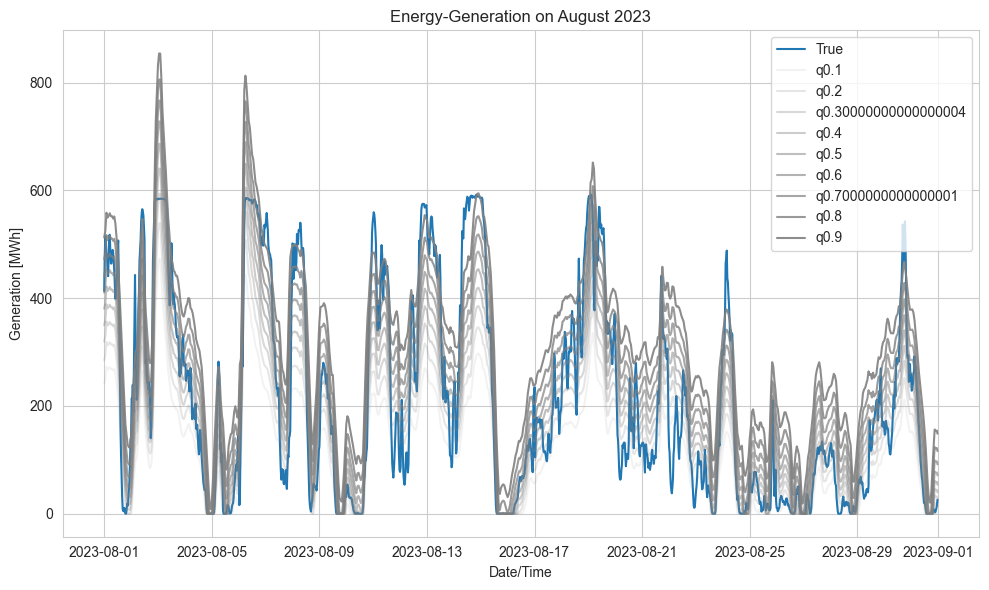

In [63]:
qr_model_wind.plot_quantils(feature_engineerer_wind_baseline.y_test.index, qr_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023)

__xgboost__

In [9]:
importlib.reload(model_utils)
import numpy as np

quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_wind"
hyperparams = {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": quantiles,
            "learning_rate": 0.01,
            "max_depth": 8
        }

xgboost_model_wind = model_utils.XGBoostModel(feature_engineerer_wind, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False, hyperparams=hyperparams, num_boost_round=45, early_stopping_rounds=10)
xgboost_model_wind.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_wind.pinball_score()}")

[0]	Train-quantile:97.92826	Val-quantile:88.89010
[1]	Train-quantile:96.87875	Val-quantile:87.93418
[2]	Train-quantile:95.83861	Val-quantile:86.98531
[3]	Train-quantile:94.81458	Val-quantile:86.05153
[4]	Train-quantile:93.80464	Val-quantile:85.13695
[5]	Train-quantile:92.80472	Val-quantile:84.23338
[6]	Train-quantile:91.81632	Val-quantile:83.34243
[7]	Train-quantile:90.84219	Val-quantile:82.45998
[8]	Train-quantile:89.88080	Val-quantile:81.59222
[9]	Train-quantile:88.92973	Val-quantile:80.73616
[10]	Train-quantile:87.99083	Val-quantile:79.88801
[11]	Train-quantile:87.06303	Val-quantile:79.05216
[12]	Train-quantile:86.14590	Val-quantile:78.21936
[13]	Train-quantile:85.24086	Val-quantile:77.40504
[14]	Train-quantile:84.34707	Val-quantile:76.59826
[15]	Train-quantile:83.46307	Val-quantile:75.79975
[16]	Train-quantile:82.59066	Val-quantile:75.01192
[17]	Train-quantile:81.72827	Val-quantile:74.23330
[18]	Train-quantile:80.87402	Val-quantile:73.46227
[19]	Train-quantile:80.03098	Val-quantile

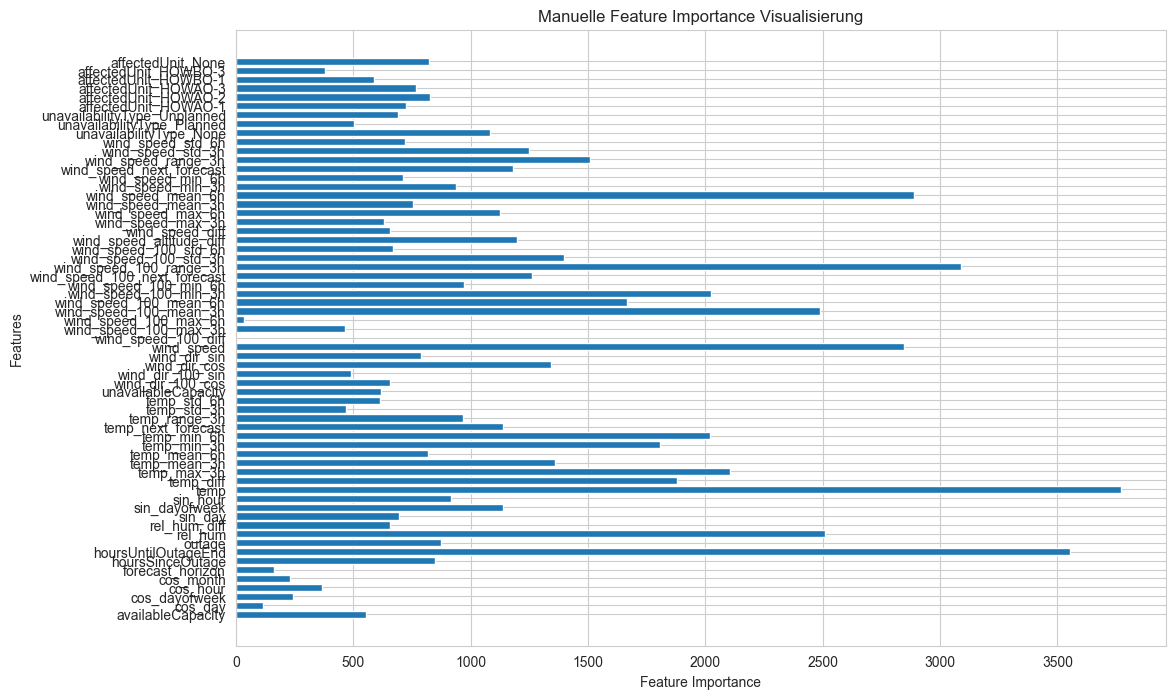

In [10]:
xgboost_model_wind.plot_feature_importance()

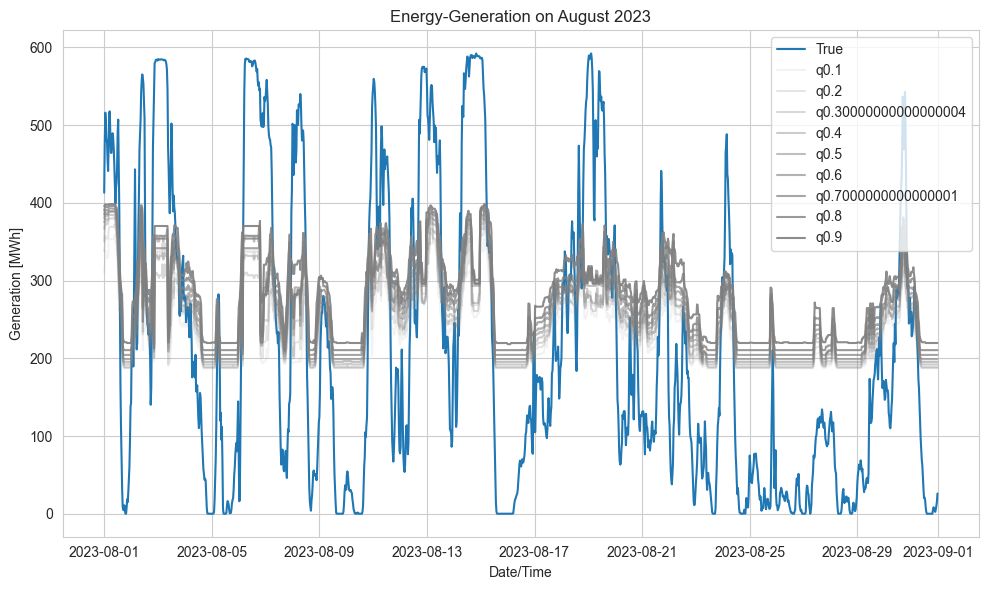

In [11]:
xgboost_model_wind.plot_quantils(daterange=feature_engineerer_wind.y_test.index, y=xgboost_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023)

### __Solar Energy Forecast__

__baseline modell__

In [12]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_solar\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_solar\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.30000000000000004 from qr_model_solar\qr_model_quantile_0.30000000000000004.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_solar\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_solar\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_solar\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7000000000000001 from qr_model_solar\qr_model_quantile_0.7000000000000001.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_solar\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_solar\qr_model_q

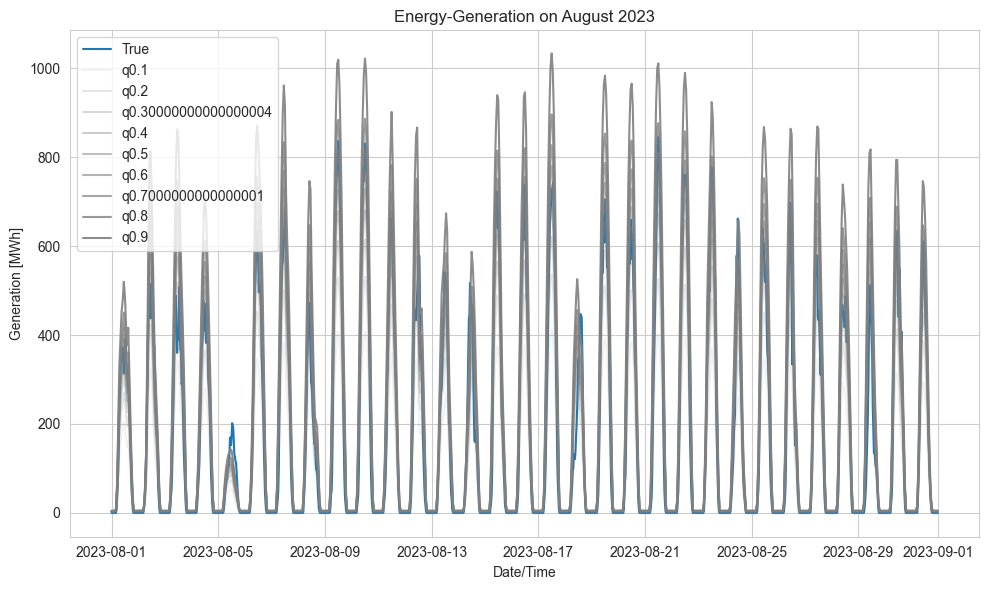

In [24]:
qr_model_solar.plot_quantils(daterange=feature_engineerer_solar_baseline.y_test.index, y=qr_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023)

__xgboost__

In [25]:
quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_solar"

xgboost_model_solar = model_utils.XGBoostModel(feature_engineerer_solar, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False)
xgboost_model_solar.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_solar.pinball_score()}")

[0]	Train-quantile:44.08707	Val-quantile:89.95057
[1]	Train-quantile:42.03986	Val-quantile:86.05513
[2]	Train-quantile:40.15751	Val-quantile:82.27772
[3]	Train-quantile:38.39230	Val-quantile:78.74044
[4]	Train-quantile:36.76298	Val-quantile:75.32009
[5]	Train-quantile:35.21154	Val-quantile:72.08206
[6]	Train-quantile:33.74628	Val-quantile:68.97437
[7]	Train-quantile:32.34835	Val-quantile:66.01293
[8]	Train-quantile:31.01052	Val-quantile:63.16004
[9]	Train-quantile:29.74307	Val-quantile:60.47123
[10]	Train-quantile:28.53109	Val-quantile:57.89782
[11]	Train-quantile:27.39076	Val-quantile:55.41591
[12]	Train-quantile:26.30762	Val-quantile:53.08895
[13]	Train-quantile:25.28495	Val-quantile:50.84766
[14]	Train-quantile:24.31522	Val-quantile:48.71098
[15]	Train-quantile:23.38586	Val-quantile:46.63809
[16]	Train-quantile:22.50596	Val-quantile:44.66774
[17]	Train-quantile:21.65688	Val-quantile:42.87176
[18]	Train-quantile:20.85787	Val-quantile:41.13363
[19]	Train-quantile:20.10806	Val-quantile

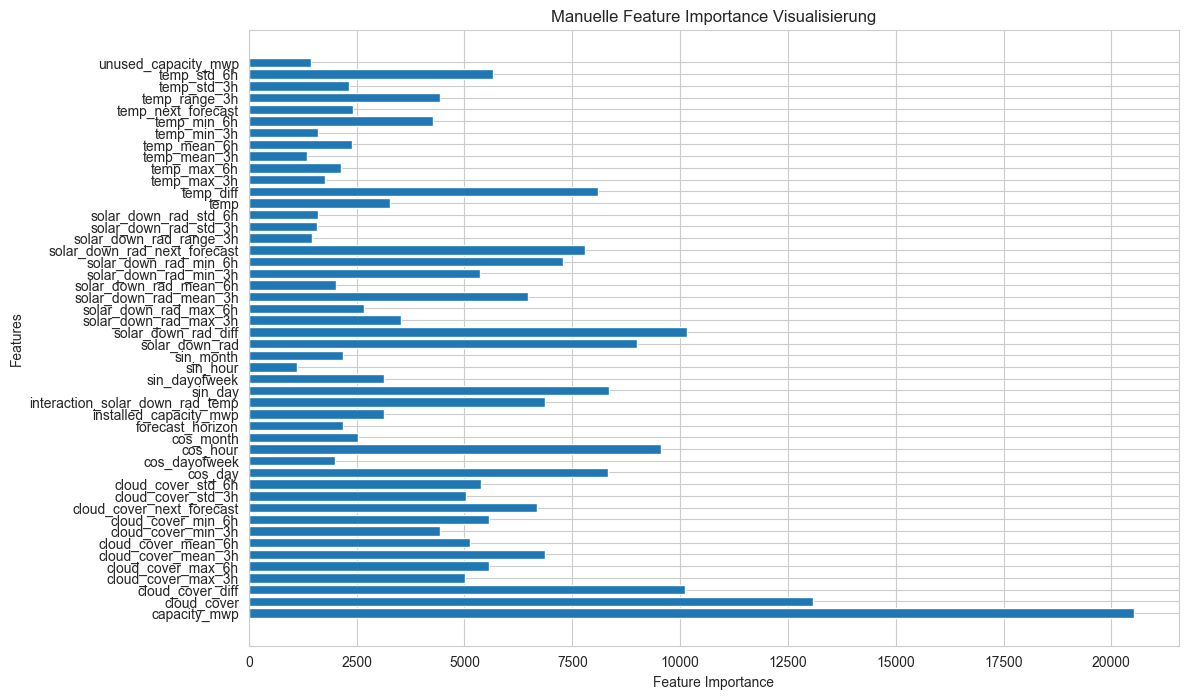

In [26]:
xgboost_model_solar.plot_feature_importance()

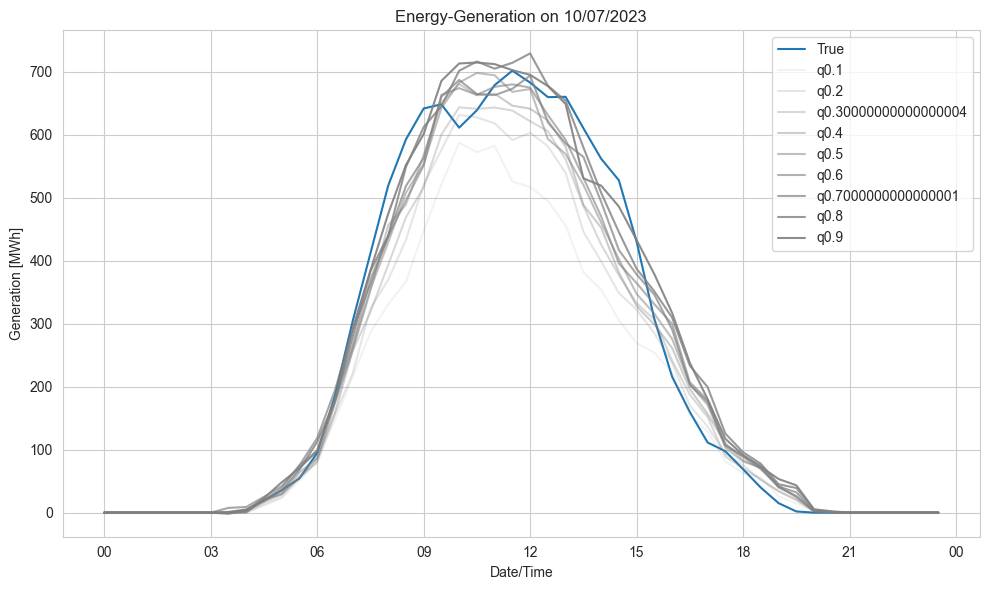

In [31]:
xgboost_model_solar.plot_quantils(daterange=feature_engineerer_solar.y_test.index, y=xgboost_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023, month = 7, day = 10)

### __Lightgbm implementation__

In [2]:
importlib.reload(model_utils)
import numpy as np
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind.pinball_score()}")

[LightGBM] [Info] Total Bins 11960
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 65
[LightGBM] [Info] Start training from score 9.924001
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 9.77323	valid's quantile: 11.6876
[100]	train's quantile: 8.28087	valid's quantile: 11.6754
Early stopping, best iteration is:
[71]	train's quantile: 9.01414	valid's quantile: 11.5612
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_wind\lgbm_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 11960
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 65
[LightGBM] [Info] Start training from score 46.169998
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 13.7512	valid's quantile: 17.9514
[100]	train's quantile: 12.1754	valid's quantile: 18.0291
Early stopping, best iteration is:
[69]	train's quantile: 13.0298	valid's quantile: 17.8291
Saved 

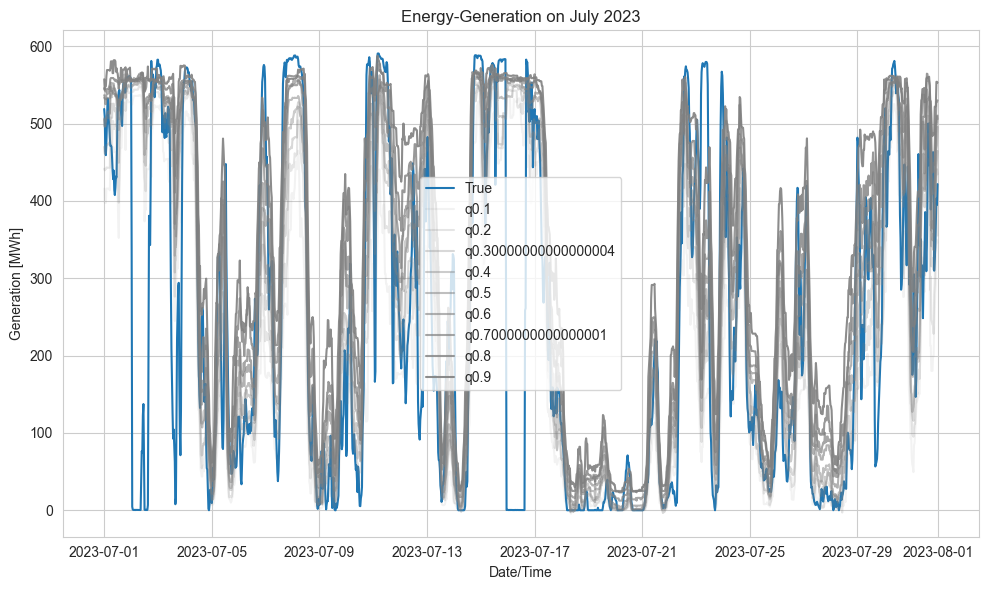

In [38]:
lgbm_model_wind.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind.q_predictions, quantiles, year = 2023, month=7)

KeyError: '0.1'

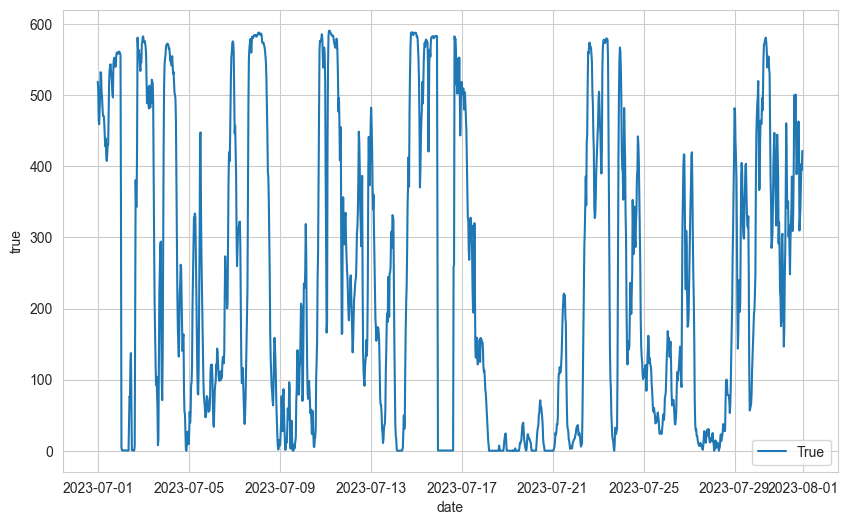

In [7]:
lgbm_model_wind.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind.q_predictions, quantiles, year = 2023, month=7)

In [8]:
lgbm_model_wind.q_predictions

{'true': array([571.652, 574.332, 569.412, ..., 581.061, 580.581, 579.661]),
 'date': DatetimeIndex(['2023-05-21 23:30:00+00:00', '2023-05-22 00:00:00+00:00',
                '2023-05-22 00:30:00+00:00', '2023-05-22 01:00:00+00:00',
                '2023-05-22 01:30:00+00:00', '2023-05-22 02:00:00+00:00',
                '2023-05-22 02:30:00+00:00', '2023-05-22 03:00:00+00:00',
                '2023-05-22 03:30:00+00:00', '2023-05-22 04:00:00+00:00',
                ...
                '2023-11-19 19:00:00+00:00', '2023-11-19 19:30:00+00:00',
                '2023-11-19 20:00:00+00:00', '2023-11-19 20:30:00+00:00',
                '2023-11-19 21:00:00+00:00', '2023-11-19 21:30:00+00:00',
                '2023-11-19 22:00:00+00:00', '2023-11-19 22:30:00+00:00',
                '2023-11-19 23:00:00+00:00', '2023-11-19 23:30:00+00:00'],
               dtype='datetime64[ns, UTC]', name='dtm', length=8737, freq=None)}

In [4]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar"

lgbm_model_solar = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar.pinball_score()}")

[LightGBM] [Info] Total Bins 10364
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 47
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 4.82569	valid's quantile: 6.40726
[100]	train's quantile: 3.79819	valid's quantile: 5.73256
Early stopping, best iteration is:
[94]	train's quantile: 3.8437	valid's quantile: 5.71441
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_solar\lgbm_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 10364
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 47
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 6.96261	valid's quantile: 9.40234
[100]	train's quantile: 5.68551	valid's quantile: 9.03766
Early stopping, best iteration is:
[81]	train's quantile: 5.91077	valid's quantile: 8.99938
Saved Quantile Regressor model for quantile 0.2 to lgbm_model_solar\lgbm_model_quantile_0.2.pkl
[LightGBM] [Info]

In [5]:
len(feature_engineerer_wind.features_after_fe)

66

In [17]:
for g in feature_engineerer_wind.features_after_fe:
    if g not in a:
        print(g)

In [19]:
len(feature_engineerer_wind.features_after_fe)

66

In [15]:
a = ['availableCapacity',
 'cos_day',
 'cos_dayofweek',
 'cos_hour',
 'cos_month',
 'forecast_horizon',
 'hoursSinceOutage',
 'hoursUntilOutageEnd',
 'outage',
 'rel_hum',
 'rel_hum_diff',
 'sin_day',
 'sin_dayofweek',
 'sin_hour',
 'sin_month',
 'temp',
 'temp_diff',
 'temp_max_3h',
 'temp_max_6h',
 'temp_mean_3h',
 'temp_mean_6h',
 'temp_min_3h',
 'temp_min_6h',
 'temp_next_forecast',
 'temp_range_3h',
 'temp_std_3h',
 'temp_std_6h',
 'unavailableCapacity',
 'wind_dir_100_cos',
 'wind_dir_100_sin',
 'wind_dir_cos',
 'wind_dir_sin',
 'wind_speed',
 'wind_speed_100',
 'wind_speed_100_diff',
 'wind_speed_100_max_3h',
 'wind_speed_100_max_6h',
 'wind_speed_100_mean_3h',
 'wind_speed_100_mean_6h',
 'wind_speed_100_min_3h',
 'wind_speed_100_min_6h',
 'wind_speed_100_next_forecast',
 'wind_speed_100_range_3h',
 'wind_speed_100_std_3h',
 'wind_speed_100_std_6h',
 'wind_speed_altitude_diff',
 'wind_speed_diff',
 'wind_speed_max_3h',
 'wind_speed_max_6h',
 'wind_speed_mean_3h',
 'wind_speed_mean_6h',
 'wind_speed_min_3h',
 'wind_speed_min_6h',
 'wind_speed_next_forecast',
 'wind_speed_range_3h',
 'wind_speed_std_3h',
 'wind_speed_std_6h',
 'unavailabilityType_None',
 'unavailabilityType_Planned',
 'unavailabilityType_Unplanned',
 'affectedUnit_HOWAO-1',
 'affectedUnit_HOWAO-2',
 'affectedUnit_HOWAO-3',
 'affectedUnit_HOWBO-1',
 'affectedUnit_HOWBO-3',
 'affectedUnit_None']

In [ ]:
import pickle

# Assuming `model` is your trained model
with open('lgbm_model_wind.pkl', 'wb') as file:
    pickle.dump(lgbm_model_wind, file)
with open('lgbm_model_solar.pkl', 'wb') as file:
    pickle.dump(lgbm_model_solar, file)

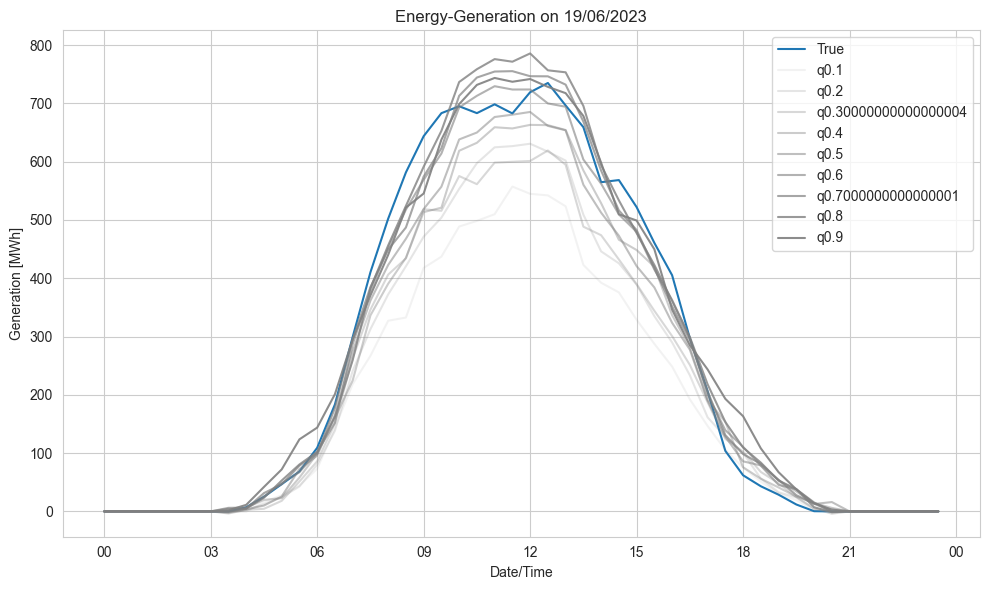

In [43]:
lgbm_model_solar.plot_quantils(feature_engineerer_solar.y_test.index, lgbm_model_solar.q_predictions, quantiles, year=2023, month=6, day=19)

In [11]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)

import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

In [34]:
import neural_networks
import numpy as np
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn
quantiles = np.arange(0.1, 1.0, 0.1)

nn_wind = neural_networks.Trainer(feature_engineerer_wind, neural_networks.q_model,quantiles)
nn_wind.train_and_test()

c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 1181.6455078125
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 1094.1888427734375
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 1025.10693359375
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 905.12646484375
40. epoche startet: 
41. epoche startet: 
42. epoche startet: 

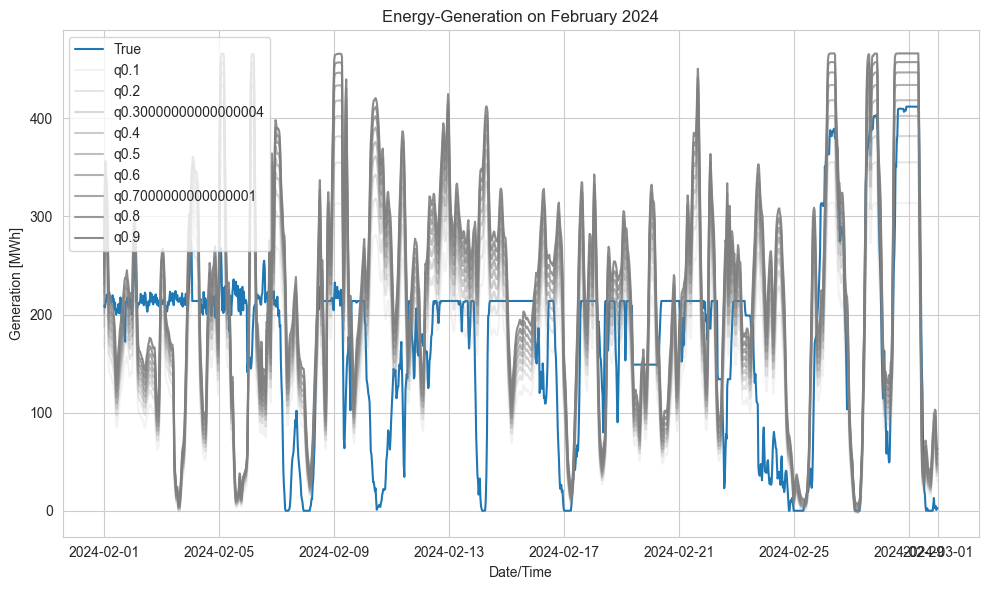

In [37]:
nn_wind.plot_quantils(feature_engineerer_wind.y_test.index, nn_wind.q_prediction_nn, quantiles, year = 2024, month = 2)

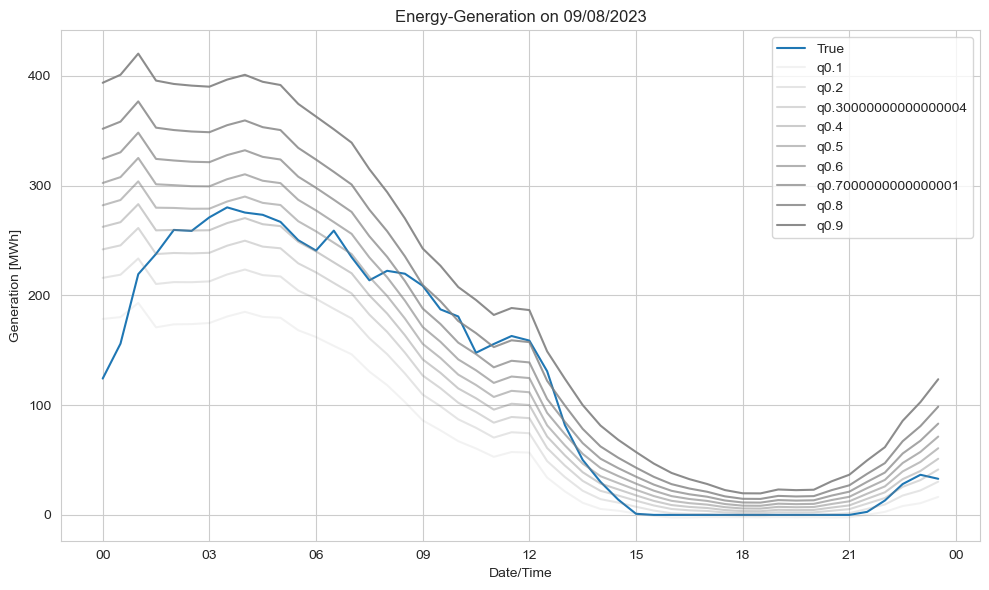

In [18]:
nn_wind.plot_quantils(feature_engineerer_wind.y_test.index, nn_wind.q_prediction_nn, quantiles, day=9)

In [19]:
import neural_networks
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn
quantiles = np.arange(0.1, 1.0, 0.1)

nn_solar = neural_networks.Trainer(feature_engineerer_solar, neural_networks.q_model, quantiles, in_shape=30)
nn_solar.train_and_test()

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 89.52793884277344
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 84.58145141601562
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 81.36831665039062
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 80.07588195800781
40. epoche startet: 
41. epoche startet: 
42. epoche start

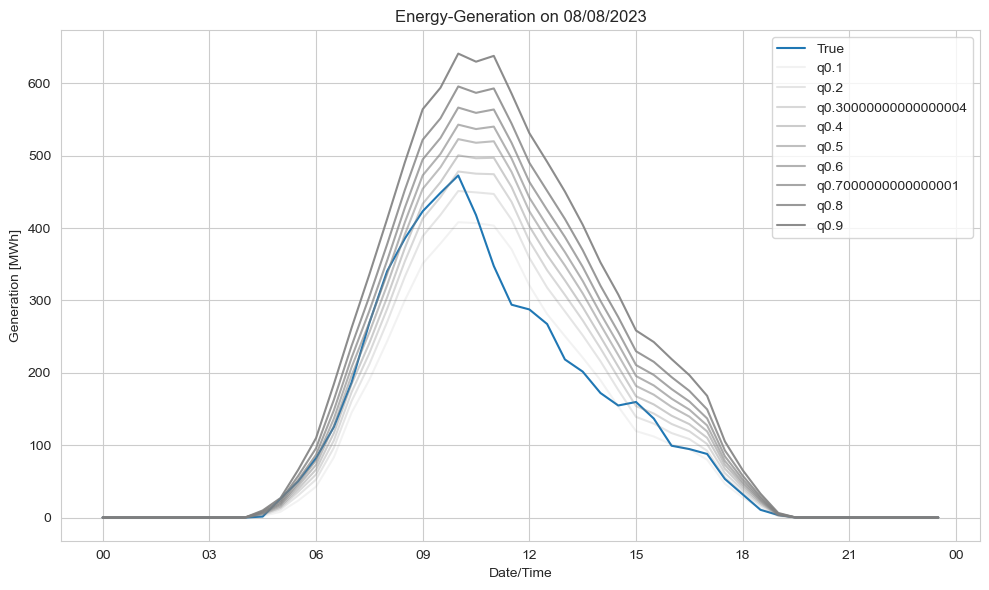

In [20]:
nn_solar.plot_quantils(feature_engineerer_solar.y_test.index, nn_solar.q_prediction_nn, quantiles, day=8)